In [1]:
%load_ext autoreload
%autoreload 2
#* magic to add python path to notebook environment
import sys
pypath = sys.path[0]
%env PYTHONPATH $pypath

import itertools

import awkward as ak
import numpy as np

from apps import cex_analyse, cex_toy_parameters
from python.analysis import cross_section, Master, Plots
from rich import print
cross_section.SetPlotStyle(True, dpi = 100)

def PlotObservableComparison(inputs : dict[cross_section.AnalysisInput], obs : str, bins, xlabel : str):
    tags = {k : cross_section.Tags.ExclusiveProcessTags(v.exclusive_process) for k, v in inputs.items()}    
    x = (bins[1:] + bins[:-1]) / 2

    styles = CreateStyles()

    for _, k in Plots.IterMultiPlot(list(tags.values())[0]):
        for e, i in enumerate(inputs):
            hist = np.histogram(getattr(inputs[i], obs)[tags[i][k].mask], bins)[0]
            Plots.Plot(x, hist/sum(hist), yerr = np.sqrt(hist)/sum(hist), color = f"C{2*e}", style = styles[e % len(styles)][0], marker = styles[e % len(styles)][1], linestyle = styles[e % len(styles)][2], label = i, title = k, newFigure = False)
        Plots.plt.xlabel(xlabel)
        Plots.plt.ylabel("fractional counts")
    return


def PlotMCToyComparison(mc : cross_section.AnalysisInput, toy : cross_section.AnalysisInput, obs : str, bins, xlabel : str):
    tags_mc = cross_section.Tags.ExclusiveProcessTags(mc.exclusive_process)
    tags_toy = cross_section.Tags.ExclusiveProcessTags(toy.exclusive_process)
    x = (bins[1:] + bins[:-1]) / 2
    for _, k in Plots.IterMultiPlot(tags_mc):
        h_m = np.histogram(getattr(mc, obs)[tags_mc[k].mask], bins)[0]
        h_t = np.histogram(getattr(toy, obs)[tags_toy[k].mask], bins)[0]
        Plots.Plot(x, h_m/sum(h_m), yerr = np.sqrt(h_m)/sum(h_m), style = "step", color = tags_mc[k].colour, label = "MC", newFigure = False)
        Plots.Plot(x, h_t/sum(h_t), yerr = np.sqrt(h_t)/sum(h_t), marker = "o", color = tags_toy[k].colour, label = "toy", linestyle = "", xlabel = xlabel, ylabel = "fractional counts", title = k, newFigure = False)
    return


def PlotAnalysisInputRatio(data1 : cross_section.AnalysisInput, data2 : cross_section.AnalysisInput, observable : str, bins : np.array, xlabel : str = None, ratio_label : str = "data2/data1", label_1 : str = "data 1", label_2 : str = "data 2", norm : float = None, weights_1 : np.array = None, weights_2 : np.array = None):
    if norm is None:
        count_1 = len(data1.inclusive_process) if weights_1 is None else sum(weights_1)
        count_2 = len(data2.inclusive_process) if weights_2 is None else sum(weights_2)
        norm = count_2/count_1
    # print(f"{count_2, count_1, count_2/count_1=}")
    h_1 = np.array(np.histogram(getattr(data1, observable), bins, weights = weights_1)[0] * norm, dtype = int)
    h_2 = np.histogram(getattr(data2, observable), bins, weights = weights_2)[0]
    with Plots.RatioPlot(bin_centers(bins), h_1, h_2, np.sqrt(h_1), np.sqrt(h_2), xlabel, ratio_label) as ratio_plot:
        Plots.Plot(ratio_plot.x, ratio_plot.y2, yerr = ratio_plot.y2_err, label=f"{label_2}: {sum(ratio_plot.y2)}", style = "step", color = "C6", newFigure = False)
        Plots.Plot(ratio_plot.x, ratio_plot.y1, yerr = ratio_plot.y1_err, label=f"{label_1}: {sum(ratio_plot.y1)}", marker = "x", linestyle = "", color = "k", ylabel = "Counts", newFigure = False)
        
        h, l = Plots.plt.gca().get_legend_handles_labels()
        Plots.plt.legend(h + [Plots.matplotlib.patches.Rectangle((0,0), 0, 0, fill = False, edgecolor='none', visible=False)], l + [f"norm: {norm:.3g}"], loc = "best", ncols = 1, labelspacing = 0.25,  columnspacing = 0.25)


def CreateStyles():
    style = ["step", "scatter"]
    marker = [None, "o", "x", "+"]
    linestyle = ["", "-", "--", "-."]

    styles = itertools.product(style, marker, linestyle)
    selected_styles = []
    for s in styles:
        if (s[0] == "step") and (s[1] is None) and (s[2] != ""): selected_styles.append(s)
        if (s[0] == "scatter") and (s[1] is None) and (s[2] != ""): selected_styles.append(s)
        if (s[0] == "scatter") and (s[1] is not None) and (s[2] == ""): selected_styles.append(s)

    selected_styles = selected_styles[:3] + selected_styles[6:] + selected_styles[3:6]
    selected_styles = selected_styles[::3] + selected_styles[1::3] + selected_styles[2::3]
    return selected_styles


def bin_centers(bins : np.array) -> np.array:
    return (bins[1:] + bins[:-1]) / 2


def CreateAnalysisInputMCTrueBeam(mc : Master.Data, args : cross_section.argparse.Namespace):
    is_pip = mc.trueParticles.pdg[:, 0] == 211
    mc_true_beam = mc.Filter([is_pip], [is_pip], True)

    n_pi =  cross_section.EventSelection.SelectionTools.GetPFOCounts(args.selection_masks["mc"]["pi"])
    n_pi0 = cross_section.EventSelection.SelectionTools.GetPFOCounts(args.selection_masks["mc"]["pi0"])
    reco_regions = cross_section.EventSelection.create_regions_new(n_pi0, n_pi)


    n_pi_true = mc_true_beam.trueParticles.nPiMinus + mc_true_beam.trueParticles.nPiPlus
    n_pi0_true = mc_true_beam.trueParticles.nPi0
    true_regions = cross_section.EventSelection.create_regions_new(n_pi0_true, n_pi_true)

    return cross_section.AnalysisInput.CreateAnalysisInputNtuple(mc_true_beam, args.beam_momentum, args.upstream_loss_correction_params["value"], reco_regions, true_regions, args.beam_reweight_params)


def CreateAnalysisInputs(args):
    mc = Master.Data(args.mc_file, nTuple_type = args.ntuple_type)
    analysis_input_mc_s = cex_analyse.CreateAnalysisInput(mc, args, True) # beam particle selection
    analysis_input_mc = CreateAnalysisInputMCTrueBeam(mc, args) # truth beam (reco regions won't work)

    analysis_input_mc.ToFile("test/analysis_inputs/analysis_input_1GeV_mc_cheated.dill")
    analysis_input_mc_s.ToFile("test/analysis_inputs/analysis_input_1GeV_mc_selected.dill")

    data = Master.Data(args.data_file, nTuple_type = args.ntuple_type)
    analysis_input_data_s = cex_analyse.CreateAnalysisInput(data, args, False)
    analysis_input_data_s.ToFile("test/analysis_inputs/analysis_input_1GeV_data_selected.dill")
    print("rerun notebook with create_ai = False")
    return


def CompareFitResults(region_fit_result, analysis_input : cross_section.AnalysisInput, energy_slices : cross_section.Slices, mean_track_score_bins : np.array, book : Plots.PlotBook = Plots.PlotBook.null):
    KE_int_prediction = cross_section.RegionFit.SliceModelPrediction(region_fit_result, slice(-1), "KE_int_postfit") # exclude the channel which is the mean track score

    total_yield_KE = np.sum(np.sum(KE_int_prediction.model_yields, 0), 1)

    print(f"{total_yield_KE, sum(total_yield_KE)=}")

    actual_yield_KE = []

    for _, (n, n_err, k) in Plots.IterMultiPlot(list(zip(np.sum(KE_int_prediction.model_yields, 0), np.sum(KE_int_prediction.total_stdev_model_bins[:, :-1], 0), analysis_input.exclusive_process.keys()))):
        true = cross_section.EnergySlice.CountingExperiment(analysis_input.KE_int_reco, analysis_input.KE_init_reco, analysis_input.outside_tpc_reco, analysis_input.exclusive_process[k], energy_slices, True)
        Plots.Plot(np.array(range(len(n))), true, label = "actual", style = "bar", color = "C6", title = f"MC | {k}", newFigure = False)
        Plots.Plot(np.array(range(len(n))), n, yerr = n_err, label = "fit", style = "step", color = "k", newFigure = False, xlabel = "$N_{int}$")
        actual_yield_KE.append(np.sum(true))
    if book: book.Save()

    print(f"{actual_yield_KE, sum(actual_yield_KE)=}")

    if mean_track_score_bins is not None:
        track_score_prediction = cross_section.RegionFit.SliceModelPrediction(region_fit_result, slice(4, 5), "mean_track_score_post")

        total_yield_score = np.sum(track_score_prediction.model_yields[0], 1)
        print(f"{total_yield_score, sum(total_yield_score)=}")

        track_scores_actual = [analysis_input.mean_track_score[analysis_input.exclusive_process[k]] for k in analysis_input.exclusive_process]

        actual_yield_score = [len(i) for i in track_scores_actual]
        print(f"{actual_yield_score, sum(actual_yield_score)=}")

        labels = list(analysis_input.exclusive_process.keys())

        Plots.plt.figure()
        for i in range(len(track_score_prediction.model_yields[0])):
            Plots.PlotHist(track_scores_actual[i], bins = mean_track_score_bins, histtype = "step", color = f"C{(2*i)}", label = labels[i], xlabel = "mean track score", newFigure = False)
            Plots.Plot((mean_track_score_bins[1:] + mean_track_score_bins[:-1]) / 2, track_score_prediction.model_yields[0][i], yerr = track_score_prediction.total_stdev_model_bins[0][i], label = "fit", color = f"C{(2*i+1)}", newFigure = False)
        book.Save()

        for i in Plots.MultiPlot(len(track_score_prediction.model_yields[0])):
            Plots.PlotHist(track_scores_actual[i], bins = mean_track_score_bins, histtype = "bar", color = f"C6", label = "actual", xlabel = "mean track score", title = labels[i], newFigure = False)
            Plots.Plot((mean_track_score_bins[1:] + mean_track_score_bins[:-1]) / 2, track_score_prediction.model_yields[0][i], yerr = track_score_prediction.total_stdev_model_bins[0][i], label = "fit", color = "k", style = "step", newFigure = False)
        book.Save()
    return


env: PYTHONPATH=/home/sb16165/Documents/pi0-analysis/analysis


In [2]:
config = "work/2023/cex_analysis_1GeV_config.json"
args = cross_section.ApplicationArguments.ResolveConfig(cross_section.LoadConfiguration(config))
# analysis_input_toy_template = cross_section.AnalysisInput.CreateAnalysisInputToy(cross_section.Toy(file = args.toy_template))
energy_slices = cross_section.Slices(50, 0, 1000, True)
energy_overflow =  np.insert(energy_slices.pos, 0, energy_slices.max_pos + energy_slices.width) # xlabels for KE, which has an overflow bin (max energy + energy bin width) 
energy_bins = np.sort(energy_overflow)
mean_track_score_bins = np.linspace(0, 1, 21, True)
create_ai = False

In [3]:
if create_ai == True:
    CreateAnalysisInputs(args)
else:
    analysis_input_mc = cross_section.AnalysisInput.FromFile("test/analysis_inputs/analysis_input_1GeV_mc_cheated.dill")
    analysis_input_mc_s =  cross_section.AnalysisInput.FromFile("test/analysis_inputs/analysis_input_1GeV_mc_selected.dill")
    analysis_input_data_s =  cross_section.AnalysisInput.FromFile("test/analysis_inputs/analysis_input_1GeV_data_selected.dill")
    # analysis_input_mc_no_rw = cross_section.AnalysisInput.FromFile("test/analysis_inputs/analysis_input_1GeV_mc_cheated_no_rw.dill")
    # analysis_input_mc_no_rw_s = cross_section.AnalysisInput.FromFile("test/analysis_inputs/analysis_input_1GeV_mc_selected_no_rw.dill")



In [4]:
config = {
    "events" : 144230,
    "step" : 0.5,
    "p_init" : 1000,
    "beam_profile" : "gaussian",
    # "beam_profile" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/beam_profile/beam_profile.json",
    "beam_width" : 60,

    "smearing_params" : {
        "KE_init" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_ff_resolution.json",
        "KE_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/KE_int_resolution.json",
        "z_int" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/smearing/track_length_resolution.json"
    },
    "reco_region_fractions" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/reco_regions/reco_region_fractions.hdf5",
    "beam_selection_efficiencies" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/pi_beam_efficiency/beam_selection_efficiencies_true.hdf5",
    "mean_track_score_kde" : "/home/sb16165/Documents/pi0-analysis/analysis/work/2023/PDSPProd4a_MC_1GeV_reco1_sce_datadriven_v1_ntuple_v09_41_00_03/toy_parameters/meanTrackScoreKDE/kdes.dill",
    "pdf_scale_factors" : None,
    "df_format" : "f",
    "modified_PDFs" : None,
    "verbose" : None,
    "seed" : None,
    "max_cpus" : 11
}

In [5]:
toy = cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_PDSP_stats.hdf5")
analysis_input_toy = cex_analyse.CreateAnalysisInput(toy, args, True) # without selection efficiency

# Comparing 1GeV toy and MC

In [6]:
def proportions(analysis_input : cross_section.AnalysisInput):
    output = {}
    output["inel"] = sum(analysis_input.exclusive_process["pion_production"]) / len(analysis_input.exclusive_process["pion_production"])
    output["charge_exchange"] = sum(analysis_input.exclusive_process["pion_production"]) / sum(analysis_input.exclusive_process["charge_exchange"])
    output["absorption"] = sum(analysis_input.exclusive_process["pion_production"]) / sum(analysis_input.exclusive_process["absorption"])
    output["single_pion_production"] = sum(analysis_input.exclusive_process["pion_production"]) / sum(analysis_input.exclusive_process["single_pion_production"])
    print(output)

proportions(cex_analyse.CreateAnalysisInput(cross_section.Toy(file = "work/2023/toys/xs_toy_1GeV_gaussian_60MeV_PDSP_stats.hdf5"), args, True, False))
proportions(analysis_input_toy)
proportions(analysis_input_mc)

# {s
#     'inel': 0.15439229009221384,
#     'charge_exchange': 1.0427046263345197,
#     'absorption': 0.5477174340810704,
#     'single_pion_production': 0.37737895503923263
# }

{
    'inel': 0.1506136032725508,
    'charge_exchange': 1.02520175562792,
    'absorption': 0.5234583965878696,
    'single_pion_production': 0.36955190364397267
}

{
    'inel': 0.1506136032725508,
    'charge_exchange': 1.02520175562792,
    'absorption': 0.5234583965878696,
    'single_pion_production': 0.36955190364397267
}

{
    'inel': 0.16915343548498926,
    'charge_exchange': 1.2378608757420468,
    'absorption': 0.5699301516107179,
    'single_pion_production': 0.42565033061744334
}

np.sum(counts, 1)/np.sum(counts)=array([0.28125639, 0.14577604, 0.41157754, 0.16139003])

np.sum(counts, 1)/np.sum(counts)=array([0.28981165, 0.14797511, 0.41050889, 0.15170434])

np.sum(counts, 1)/np.sum(counts)=array([0.29464939, 0.14800904, 0.41017602, 0.14716555])

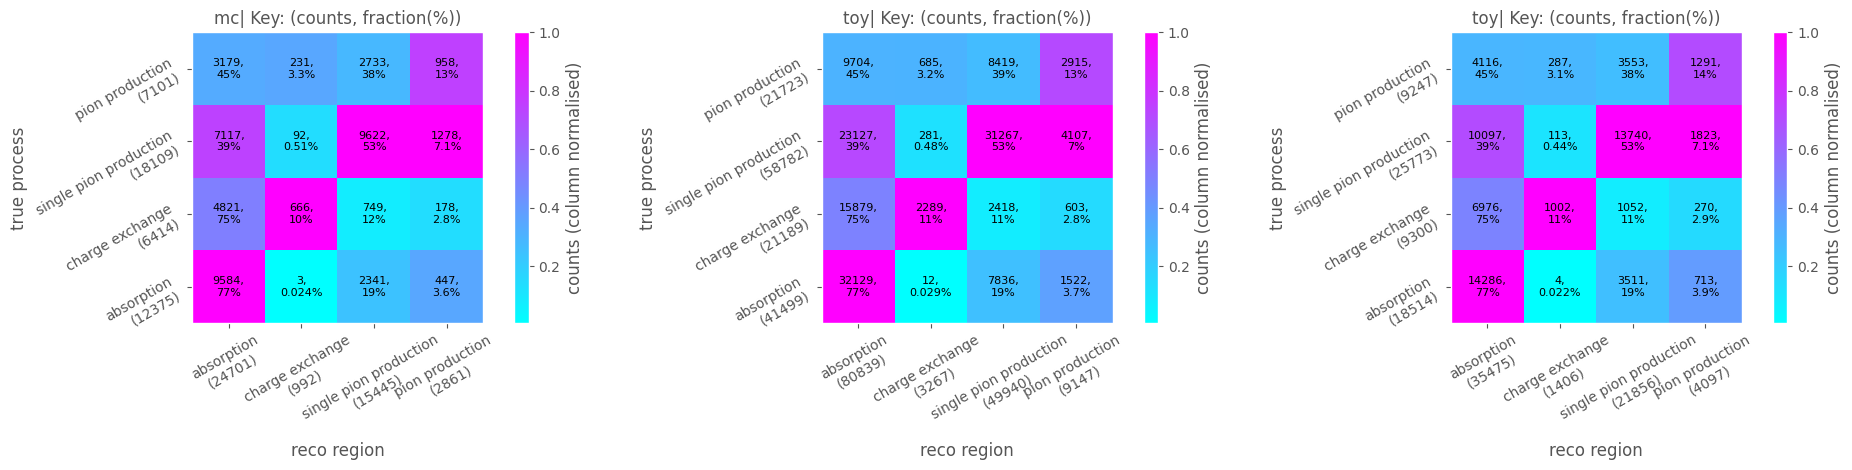

In [7]:
plot = Plots.MultiPlot(3)
next(plot)
counts = cross_section.Toy.ComputeCounts(analysis_input_mc_s.exclusive_process, analysis_input_mc_s.regions)
print(f"{np.sum(counts, 1)/np.sum(counts)=}")
cex_toy_parameters.PlotCorrelationMatrix(counts, list(analysis_input_mc_s.exclusive_process.keys()), list(analysis_input_mc_s.regions.keys()), "mc", newFigure = False)
next(plot)
counts = cross_section.Toy.ComputeCounts(analysis_input_toy.exclusive_process, analysis_input_toy.regions)
print(f"{np.sum(counts, 1)/np.sum(counts)=}")
cex_toy_parameters.PlotCorrelationMatrix(counts, list(analysis_input_toy.exclusive_process.keys()), list(analysis_input_toy.regions.keys()), "toy", newFigure = False)
next(plot)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


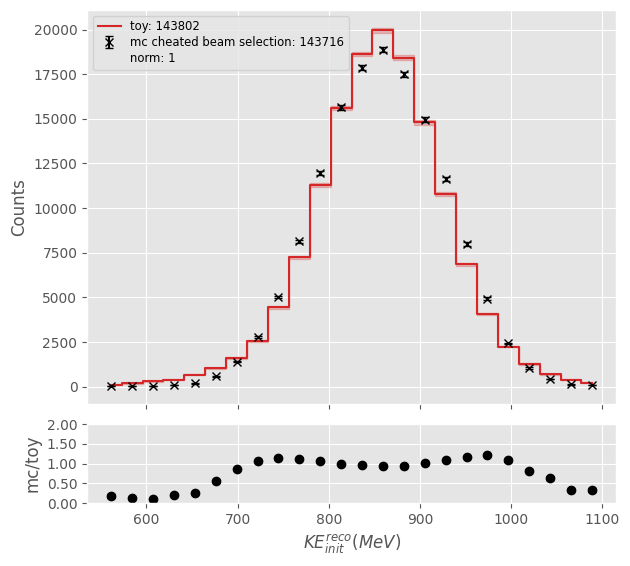

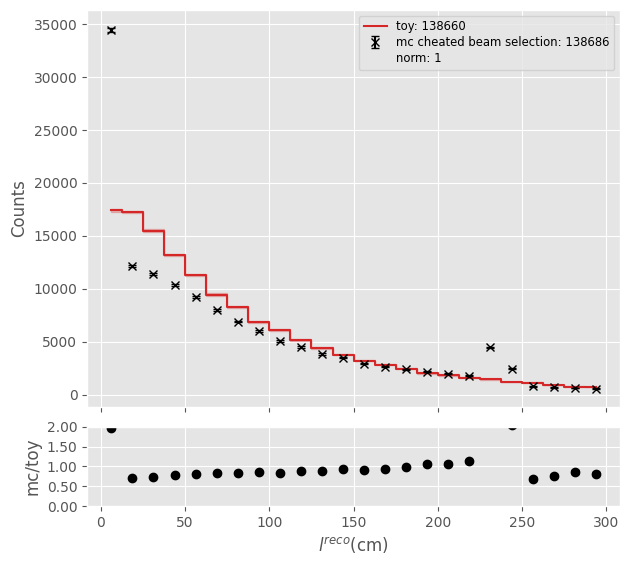

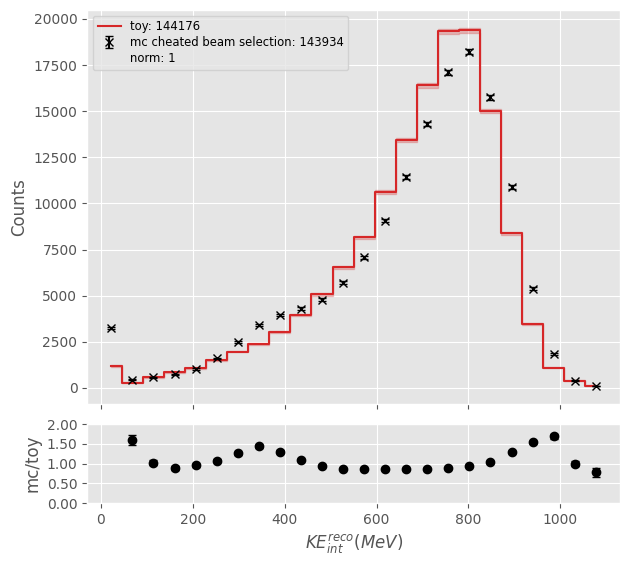

In [9]:
with Plots.PlotBook("toy_vs_cheated_selection.pdf", False) as book:
    PlotAnalysisInputRatio(analysis_input_mc, analysis_input_toy, "KE_init_reco", np.linspace(550, 1100, 25), "$KE_{init}^{reco}(MeV)$", "mc/toy", "mc cheated beam selection", "toy")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc, analysis_input_toy, "track_length_reco", np.linspace(0, 300, 25), "$l^{reco}$(cm)", "mc/toy", "mc cheated beam selection", "toy")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc, analysis_input_toy, "KE_int_reco", np.linspace(0, 1100, 25), "$KE_{int}^{reco}(MeV)$", "mc/toy", "mc cheated beam selection", "toy")
    book.Save()

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:1592: RuntimeWarning: invalid value encountered in divide
  ratio_err = abs(ratio * np.sqrt((self.y1_err/self.y1)**2 + (self.y2_err/self.y2)**2))


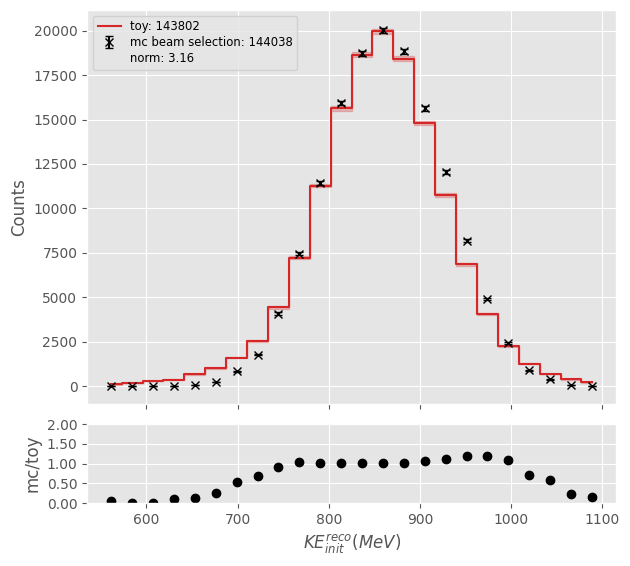

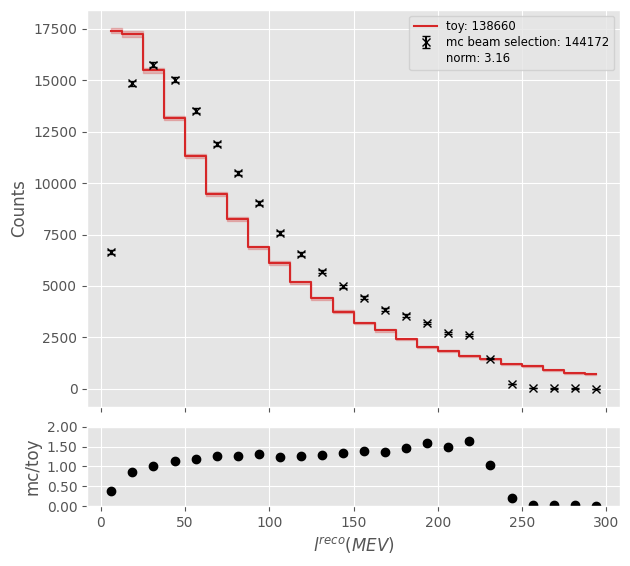

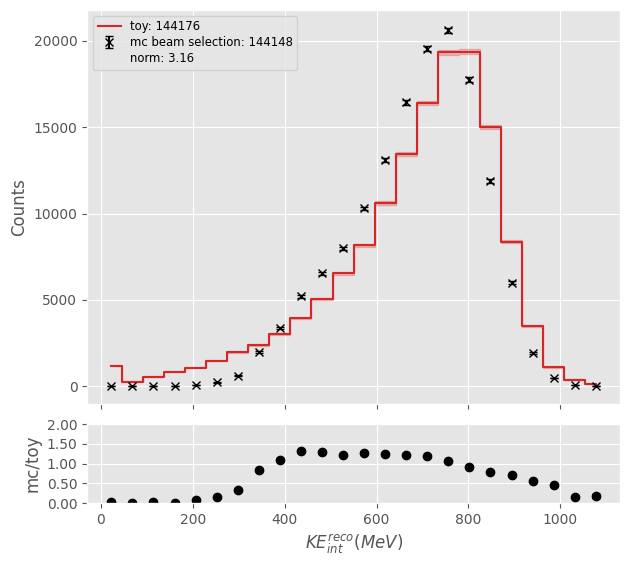

In [10]:
with Plots.PlotBook("toy_vs_beam_selection.pdf", False) as book:
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy, "KE_init_reco", np.linspace(550, 1100, 25), "$KE_{init}^{reco}(MeV)$", "mc/toy", "mc beam selection", "toy")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy, "track_length_reco", np.linspace(0, 300, 25), "$l^{reco}(MEV)$", "mc/toy", "mc beam selection", "toy")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy, "KE_int_reco", np.linspace(0, 1100, 25), "$KE_{int}^{reco}(MeV)$", "mc/toy", "mc beam selection", "toy")
    book.Save()

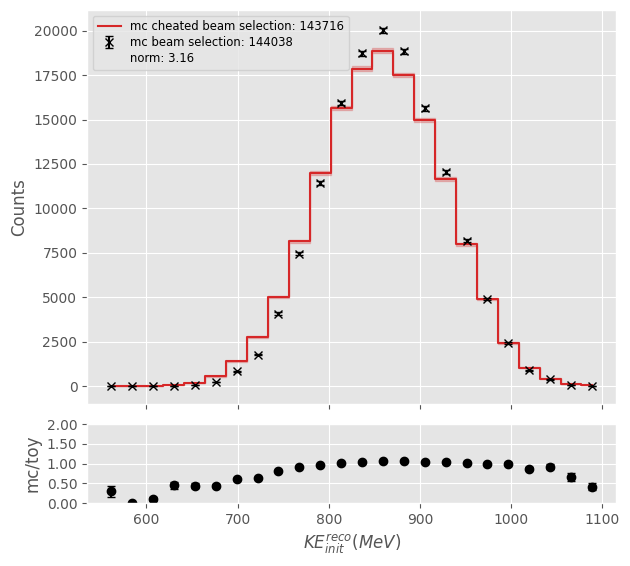

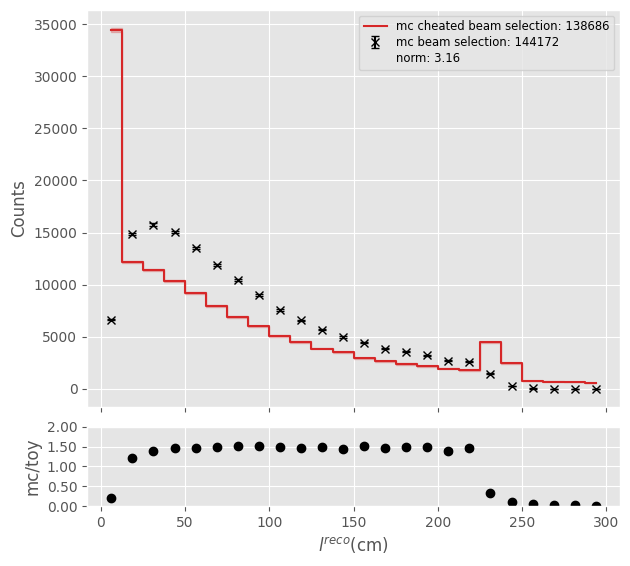

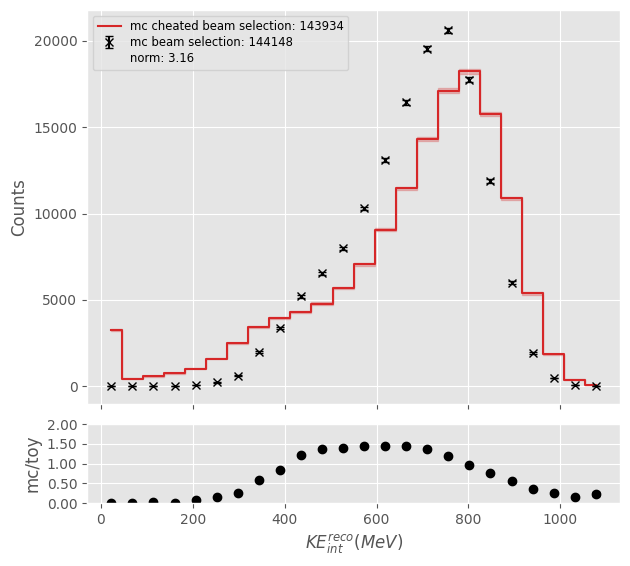

In [12]:
with Plots.PlotBook("beam_selection_vs_cheated_selection.pdf", False) as book:
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_mc, "KE_init_reco", np.linspace(550, 1100, 25), "$KE_{init}^{reco}(MeV)$", "mc/toy", "mc beam selection", "mc cheated beam selection")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_mc, "track_length_reco", np.linspace(0, 300, 25), "$l^{reco}$(cm)", "mc/toy", "mc beam selection", "mc cheated beam selection")
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_mc, "KE_int_reco", np.linspace(0, 1100, 25), "$KE_{int}^{reco}(MeV)$", "mc/toy", "mc beam selection", "mc cheated beam selection")
    book.Save()

In [14]:
print({k : sum(v) / len(v) for k, v in analysis_input_mc_s.regions.items()})
print({k : sum(v) / len(v) for k, v in analysis_input_toy.regions.items()})

{
    'absorption': 0.5419143941554595,
    'charge_exchange': 0.021763454070775103,
    'single_pion_production': 0.3388473267370176,
    'pion_production': 0.06276738114565279
}

{
    'absorption': 0.5604867225958539,
    'charge_exchange': 0.022651320807044305,
    'single_pion_production': 0.34625251334673784,
    'pion_production': 0.06341953823753727
}

 - alter the proportion of processes in toy to match MC, redo fit

 - perfect reweight of toy template?
 - selection efficiency weights per exclusive process

# Efficiency Weights

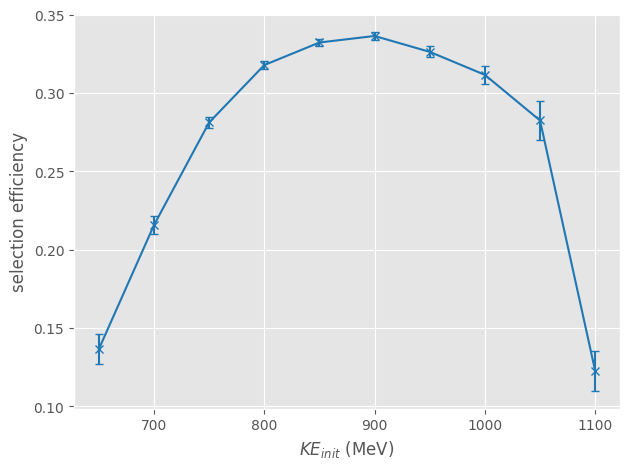

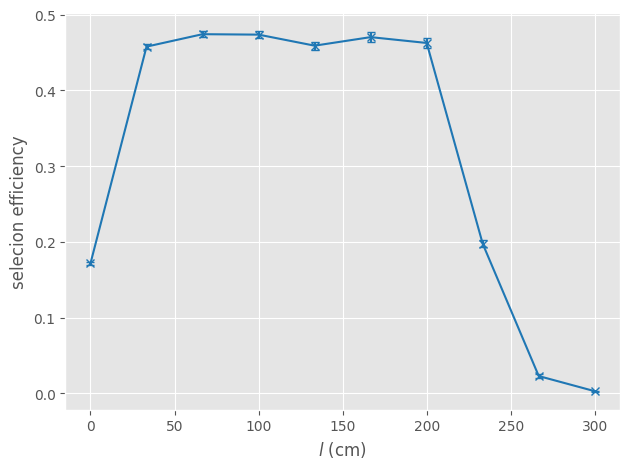

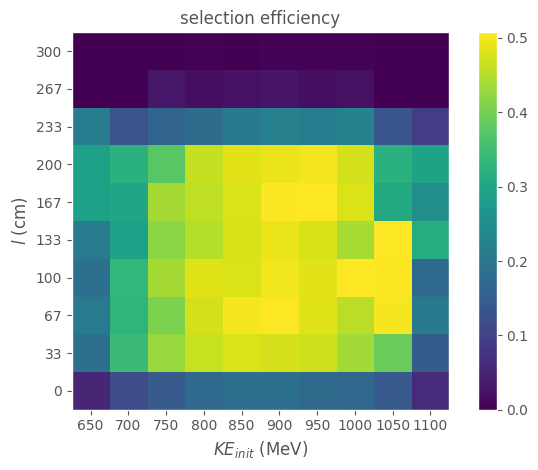

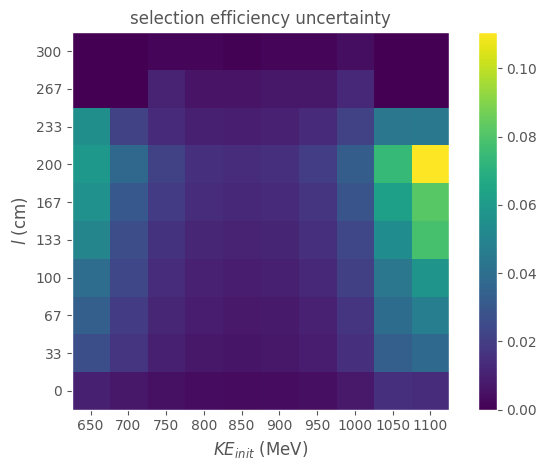

In [15]:
def MakeMatrix(analysis_input : cross_section.AnalysisInput, bins : int, x_range, y_range, process : str = None):
    
    l = analysis_input.track_length_reco[analysis_input.exclusive_process[process]] if process is not None else analysis_input.track_length_reco
    e = analysis_input.KE_init_reco[analysis_input.exclusive_process[process]] if process is not None else analysis_input.KE_init_reco

    x = np.array(np.clip(l, min(x_range), max(x_range)))
    y = np.array(np.clip(e, min(y_range), max(y_range)))
    return np.histogram2d(x, y, bins = bins, range = [x_range, y_range])[0]

def EfficiencyMatrix(data_selected, data_cheated, bins : int, track_length_range = [0, 300], KE_init_range = [650, 1100], process : str = None, book : Plots.PlotBook = None):
    h_selected = MakeMatrix(data_selected, bins, track_length_range, KE_init_range, process)
    h_cheated = MakeMatrix(data_cheated, bins, track_length_range, KE_init_range, process)
    # fractions = h_selected / h_cheated

    fractions, errors = cex_toy_parameters.Efficiency(h_selected, h_cheated)

    fractions = np.where(np.isnan(fractions), 0, fractions)
    fractions = np.where(abs(fractions) == np.inf, 0, fractions)

    bins_KE = np.linspace(*KE_init_range, bins)
    bins_trklen = np.linspace(*track_length_range, bins)

    f, e = cex_toy_parameters.Efficiency(np.sum(h_selected, 0), np.sum(h_cheated, 0))
    Plots.Plot(bins_KE, f, yerr = e, marker = "x", xlabel = "$KE_{init}$ (MeV)", ylabel = "selection efficiency")
    if book is not None: book.Save()

    f, e = cex_toy_parameters.Efficiency(np.sum(h_selected, 1), np.sum(h_cheated, 1))
    Plots.Plot(bins_trklen, f, yerr = e, marker = "x", xlabel = "$l$ (cm)", ylabel = "selecion efficiency")
    if book is not None: book.Save()

    KE_ticks = [f"{i:.0f}" for i in bins_KE]
    trklen_ticks = [f"{i:.0f}" for i in bins_trklen]

    Plots.plt.figure()
    Plots.plt.imshow(fractions, origin = "lower") #extent = (650, 1100, 0, 300), aspect = (1100 - 650)/(300 - 0))
    Plots.plt.colorbar()

    Plots.plt.gca().set_xticks(np.arange(len(bins_KE)), labels=KE_ticks)
    Plots.plt.gca().set_yticks(np.arange(len(bins_trklen)), labels=trklen_ticks)
    Plots.plt.xlabel("$KE_{init}$ (MeV)")
    Plots.plt.ylabel("$l$ (cm)")
    Plots.plt.grid(False)
    Plots.plt.title("selection efficiency")
    Plots.plt.tight_layout()
    if book is not None: book.Save()

    Plots.plt.figure()
    Plots.plt.imshow(errors, origin = "lower") #extent = (650, 1100, 0, 300), aspect = (1100 - 650)/(300 - 0))
    Plots.plt.colorbar()

    Plots.plt.gca().set_xticks(np.arange(len(bins_KE)), labels=KE_ticks)
    Plots.plt.gca().set_yticks(np.arange(len(bins_trklen)), labels=trklen_ticks)
    Plots.plt.xlabel("$KE_{init}$ (MeV)")
    Plots.plt.ylabel("$l$ (cm)")
    Plots.plt.grid(False)
    Plots.plt.title("selection efficiency uncertainty")
    Plots.plt.tight_layout()
    if book is not None: book.Save()


    return fractions

fractions = EfficiencyMatrix(analysis_input_mc_s, analysis_input_mc, 10)

In [16]:
def CreateWeights(KE_init_reco, track_length_reco, weights_matrix, bins):
    column_ind = np.digitize(np.clip(KE_init_reco, 650, 1100), np.linspace(650, 1100, bins)) - 1
    row_ind = np.digitize(np.clip(track_length_reco, 0, 300), np.linspace(0, 300, bins)) - 1
    toy_weights = weights_matrix.flatten()[(row_ind * bins) + column_ind]
    return toy_weights

toy_weights = CreateWeights(analysis_input_toy_template.KE_init_reco, analysis_input_toy_template.track_length_reco, fractions, 10)

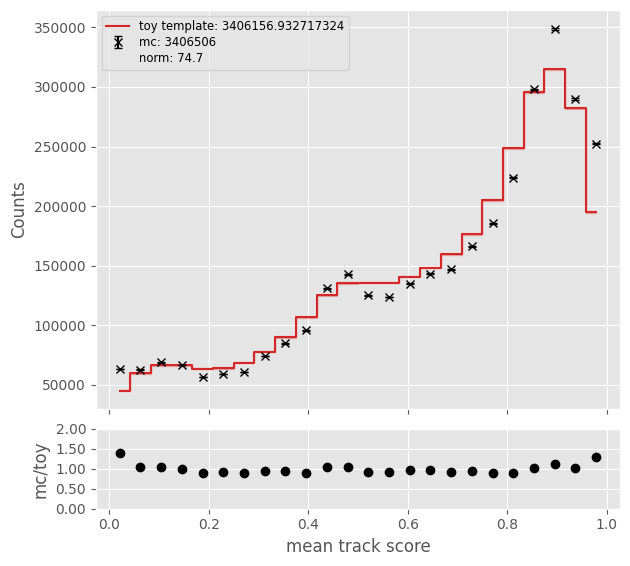

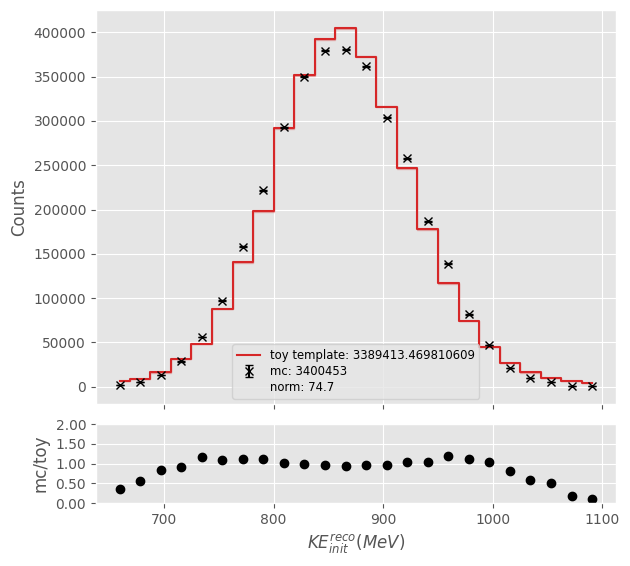

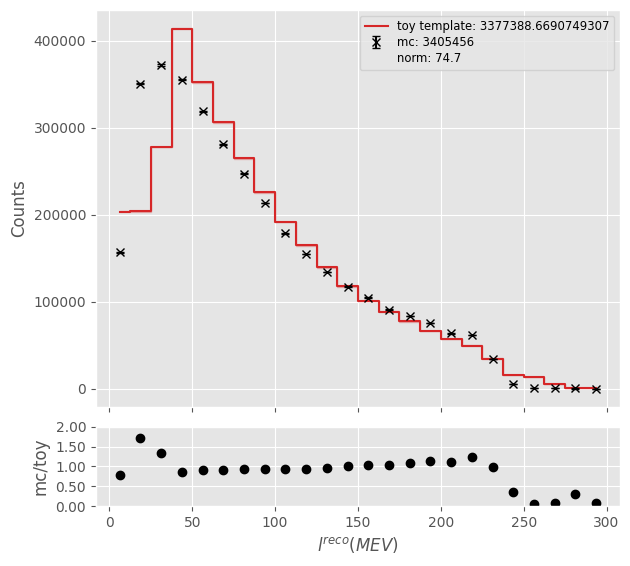

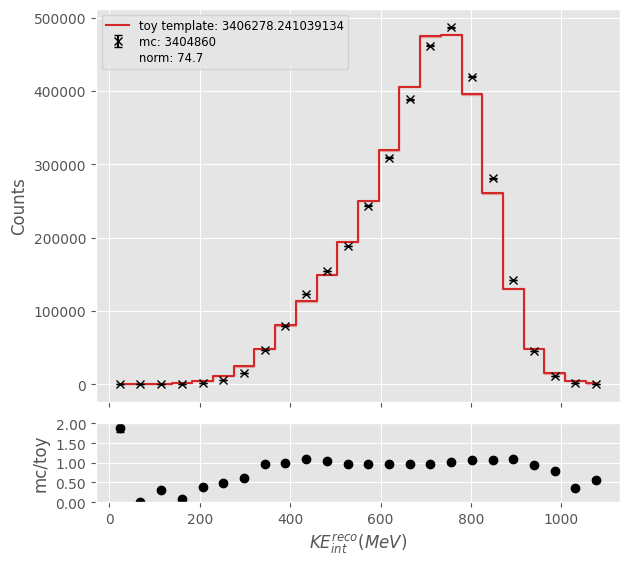

In [17]:
with Plots.PlotBook("ratio_plot_weighted.pdf", False) as book:
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy_template, "mean_track_score", np.linspace(0, 1, 25), "mean track score", "mc/toy", "mc", "toy template", weights_2 = toy_weights)
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy_template, "KE_init_reco", np.linspace(650, 1100, 25), "$KE_{init}^{reco}(MeV)$", "mc/toy", "mc", "toy template", weights_2 = toy_weights)
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy_template, "track_length_reco", np.linspace(0, 300, 25), "$l^{reco}(MEV)$", "mc/toy", "mc", "toy template", weights_2 = toy_weights)
    book.Save()
    PlotAnalysisInputRatio(analysis_input_mc_s, analysis_input_toy_template, "KE_int_reco", np.linspace(0, 1100, 25), "$KE_{int}^{reco}(MeV)$", "mc/toy", "mc", "toy template", weights_2 = toy_weights)
    book.Save()


# Region Fit

## MC template

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 23, 'channel_1': 23, 'channel_2': 23, 'channel_3': 23, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_sample_0_pois_err', 'shapesys'), ('channel_0_sample_1_pois_err', 'shapesys'), ('channel_0_sample_2_pois_err', 'shapesys'), ('channel_0_sample_3_pois_err', 'shapesys'), ('channel_1_sample_0_pois_err', 'shapesys'), ('channel_1_sample_1_pois_err', 'shapesys'), ('channel_1_sample_2_pois_err', 'shapesys'), ('channel_1_sample_3_pois_err', 'shapesys'), ('channel_2_sample_0_pois_err', 'shapesys'), ('channel_2_sample_1_pois_err', 'shapesys'), ('channel_2_sample_2_pois_err', 'shapesys'), ('channel_2_sample_3_pois_err', 'shapesys'), ('channel_3_sample_0_pois_err', 'shapesys'), ('channel_3_sample_1_pois_err', 'shapesys'), ('channel_3_sample_2_pois_err', 'shapesys'), ('channel_3_sample_3_pois_err', 'shapesys'), ('mean_track_sco

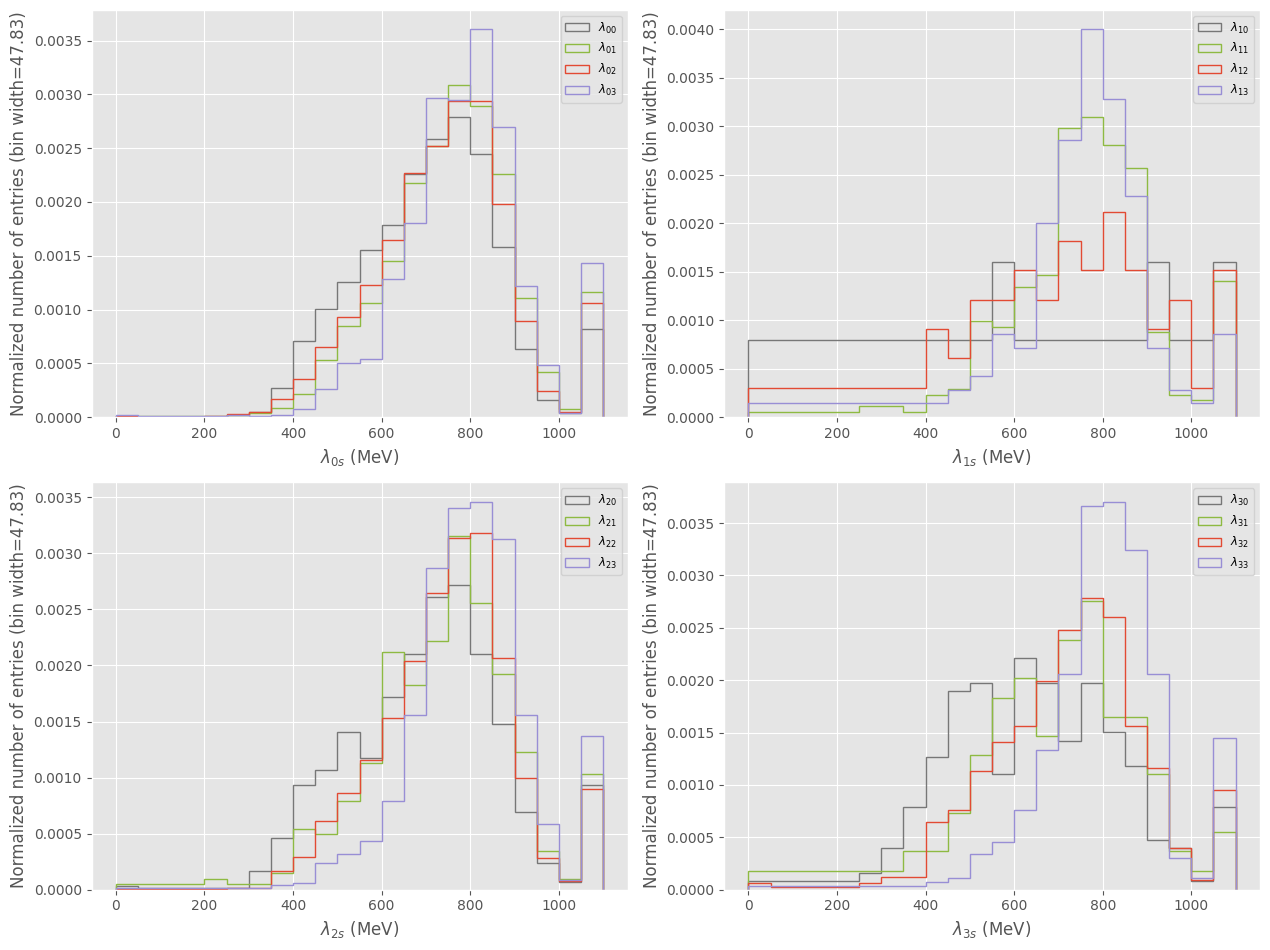

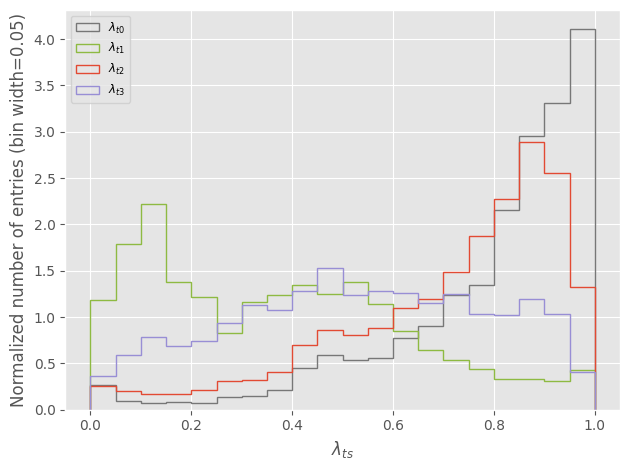

In [19]:
def RegionFitMC(fit_input : cross_section.AnalysisInput, energy_slice : cross_section.Slices, mean_track_score_bins : np.array, template : cross_section.AnalysisInput, suggest_init : bool = False) -> cross_section.cabinetry.model_utils.ModelPrediction:

    model = cross_section.RegionFit.CreateModel(template, energy_slice, mean_track_score_bins, False)

    observed = cross_section.RegionFit.GenerateObservations(fit_input, energy_slice, mean_track_score_bins, model)

    if suggest_init is True:
        init_params = cex_analyse.CreateInitParams(model, fit_input, energy_slice, mean_track_score_bins)
    else:
        init_params = None

    result = cross_section.RegionFit.Fit(observed, model, init_params, verbose = True)
    return cross_section.cabinetry.model_utils.prediction(model, fit_results = result)


energy_overflow =  np.insert(energy_slices.pos, 0, energy_slices.max_pos + energy_slices.width) # xlabels for KE, which has an overflow bin (max energy + energy bin width) 
energy_bins = np.sort(energy_overflow)

analysis_input_mc_split = cross_section.AnalysisInput.CreateTrainTestSamples(analysis_input_mc_s, 1, 0.5)
model, templates_energy, templates_mean_track_score = cross_section.RegionFit.CreateModel(analysis_input_mc_split["train"], energy_slices, mean_track_score_bins, True)

tags = cross_section.Tags.ExclusiveProcessTags(analysis_input_mc_split["train"].exclusive_process)
for j, c in Plots.IterMultiPlot(templates_energy):
    for i, s in enumerate(c):
        Plots.PlotHist(energy_overflow, energy_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{{j}{i}}}$", xlabel = f"$\lambda_{{{j}s}}$ (MeV)", histtype = "step", newFigure = False, density = True)

Plots.plt.figure()
for i, s in enumerate(templates_mean_track_score):
    Plots.PlotHist(bin_centers(mean_track_score_bins), mean_track_score_bins, weights = s, color = tags.number[i].colour, label = f"$\lambda_{{t{i}}}$", xlabel = f"$\lambda_{{ts}}$", histtype = "step", newFigure = False, density = True)
Plots.plt.legend(loc = "upper left")

template size 22790, data size 22791

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 23, 'channel_1': 23, 'channel_2': 23, 'channel_3': 23, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_sample_0_pois_err', 'shapesys'), ('channel_0_sample_1_pois_err', 'shapesys'), ('channel_0_sample_2_pois_err', 'shapesys'), ('channel_0_sample_3_pois_err', 'shapesys'), ('channel_1_sample_0_pois_err', 'shapesys'), ('channel_1_sample_1_pois_err', 'shapesys'), ('channel_1_sample_2_pois_err', 'shapesys'), ('channel_1_sample_3_pois_err', 'shapesys'), ('channel_2_sample_0_pois_err', 'shapesys'), ('channel_2_sample_1_pois_err', 'shapesys'), ('channel_2_sample_2_pois_err', 'shapesys'), ('channel_2_sample_3_pois_err', 'shapesys'), ('channel_3_sample_0_pois_err', 'shapesys'), ('channel_3_sample_1_pois_err', 'shapesys'), ('channel_3_sample_2_pois_err', 'shapesys'), ('channel_3_sample_3_pois_err', 'shapesys'), ('mean_track_sco

total_yield_KE, sum(total_yield_KE)=(array([6428.76241975, 3149.10806591, 8922.23570063, 3777.73782314]), 
22277.844009430555)

actual_yield_KE, sum(actual_yield_KE)=([6133, 3352, 8928, 3549], 21962)

total_yield_score, sum(total_yield_score)=(array([6469.84938932, 3165.73848194, 9034.27461287, 3805.29677197]), 
22475.15925610684)

actual_yield_score, sum(actual_yield_score)=([6133, 3352, 8928, 3549], 21962)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


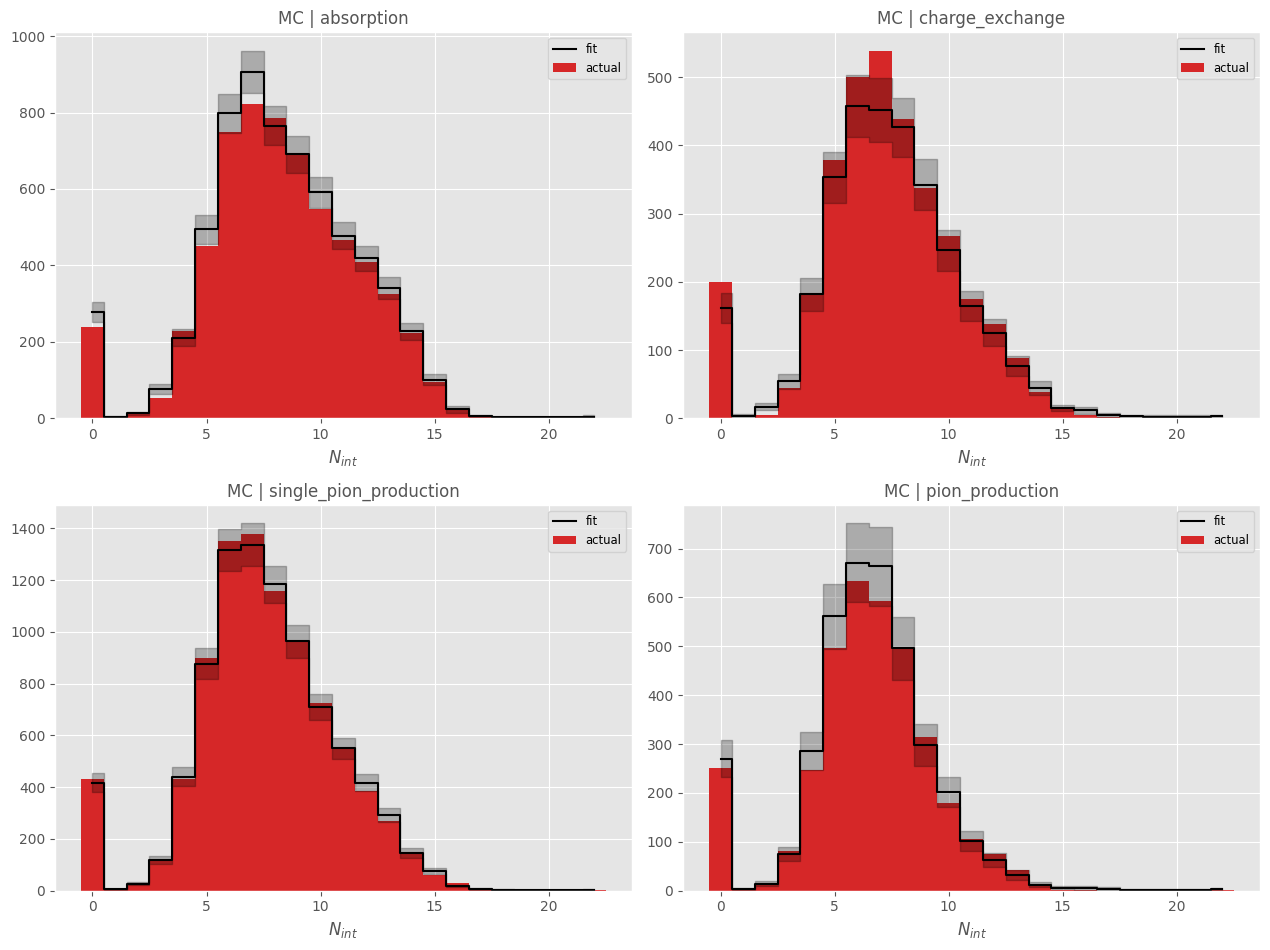

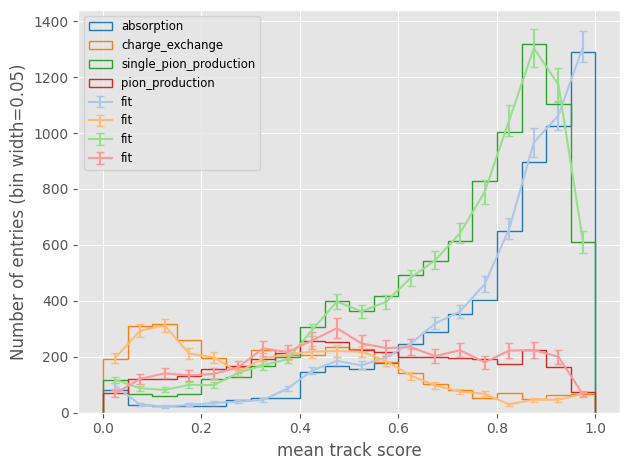

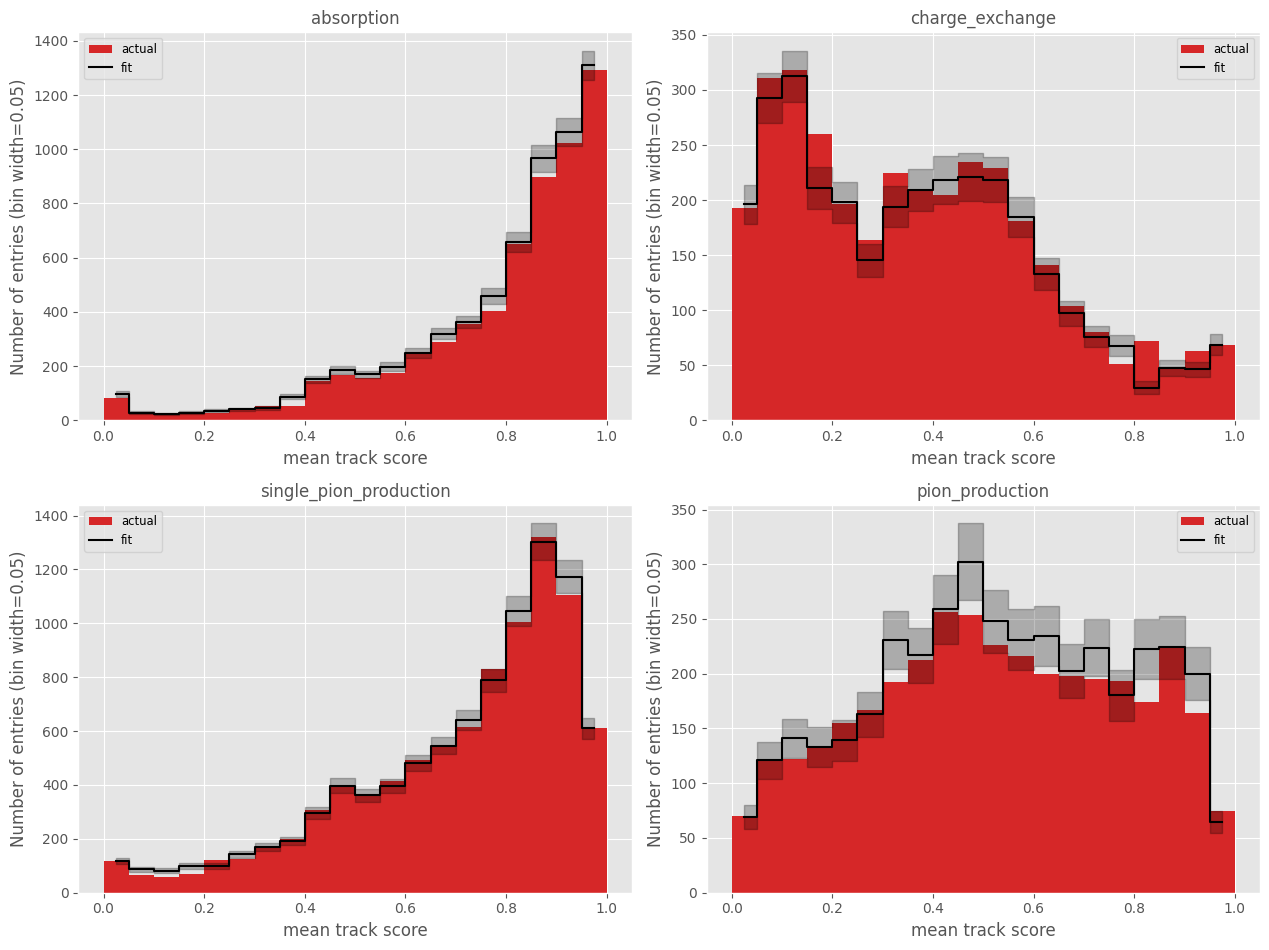

In [20]:
def FitStudyMC(mc_sample = cross_section.AnalysisInput, seed : int = 1, train_fraction : float = 0.5, book : Plots.PlotBook = Plots.PlotBook.null):
    train, test = cross_section.AnalysisInput.CreateTrainTestSamples(mc_sample, seed, train_fraction).values()
    print(f"template size {len(train.KE_init_true)}, data size {len(test.KE_init_true)}")
    region_fit_result = RegionFitMC(test, energy_slices, mean_track_score_bins, train, False)
    CompareFitResults(region_fit_result, test, book)
    return

book = Plots.PlotBook("mc_region_fit_mc_template.pdf", False)
FitStudyMC(analysis_input_mc_s, 10, 0.5, book)
book.close()

## Nll scan

In [299]:
def NllScan(param : str, fit_input : cross_section.AnalysisInput, energy_slice : cross_section.Slices, toy_template : cross_section.Toy, suggest_init : bool = True) -> cross_section.cabinetry.model_utils.ModelPrediction:
    mean_track_score_bins = np.linspace(0, 1, 21, True) #! make configurable

    model, _, _ = cross_section.RegionFit.CreateModel(toy_template, energy_slice, mean_track_score_bins, True)

    observed = cross_section.RegionFit.GenerateObservations(fit_input, energy_slice, mean_track_score_bins, model)

    if suggest_init is True:
        init_params = cex_analyse.CreateInitParams(model, fit_input, energy_slice, mean_track_score_bins)
    else:
        init_params = None

    return cross_section.cabinetry.fit.scan(model, observed, param, init_pars = init_params, custom_fit = True, tolerance = 0.01)

In [ ]:
for i in range(4):
    print(f"mu_{i}")
    region_fit_result = NllScan(f"mu_{i}", analysis_input_mc, energy_slices, args.toy_template, True)
    cross_section.cabinetry.visualize.scan(region_fit_result)

## toy template

In [25]:
def FitStudy(analysis_input, template_input : cross_section.AnalysisInput, book : Plots.PlotBook, template_weights : bool = None):
    region_fit_result = cex_analyse.RegionFit(analysis_input, energy_slices, mean_track_score_bins, template_input, suggest_init = False, beam_selection = False, template_weights = template_weights)
    # 6333.982696725586 # looked OK
    # 6248.008381092954 # looks bad
    CompareFitResults(region_fit_result, analysis_input, book)
    return region_fit_result

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3', 'mean_track_score']
     nbins: {'channel_0': 23, 'channel_1': 23, 'channel_2': 23, 'channel_3': 23, 'mean_track_score': 20}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_sample_0_pois_err', 'shapesys'), ('channel_0_sample_1_pois_err', 'shapesys'), ('channel_0_sample_2_pois_err', 'shapesys'), ('channel_0_sample_3_pois_err', 'shapesys'), ('channel_1_sample_0_pois_err', 'shapesys'), ('channel_1_sample_1_pois_err', 'shapesys'), ('channel_1_sample_2_pois_err', 'shapesys'), ('channel_1_sample_3_pois_err', 'shapesys'), ('channel_2_sample_0_pois_err', 'shapesys'), ('channel_2_sample_1_pois_err', 'shapesys'), ('channel_2_sample_2_pois_err', 'shapesys'), ('channel_2_sample_3_pois_err', 'shapesys'), ('channel_3_sample_0_pois_err', 'shapesys'), ('channel_3_sample_1_pois_err', 'shapesys'), ('channel_3_sample_2_pois_err', 'shapesys'), ('channel_3_sample_3_pois_err', 'shapesys'), ('mean_track_sco

total_yield_KE, sum(total_yield_KE)=(array([13440.95898754,  6368.02436649, 18164.54053341,  6808.6293573 ]), 
44782.153244744906)

actual_yield_KE, sum(actual_yield_KE)=([12375, 6414, 18109, 7101], 43999)

total_yield_score, sum(total_yield_score)=(array([13453.87329984,  6368.89251538, 18168.55744694,  6806.55538732]),
44797.87864948841)

actual_yield_score, sum(actual_yield_score)=([12375, 6414, 18109, 7101], 43999)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")


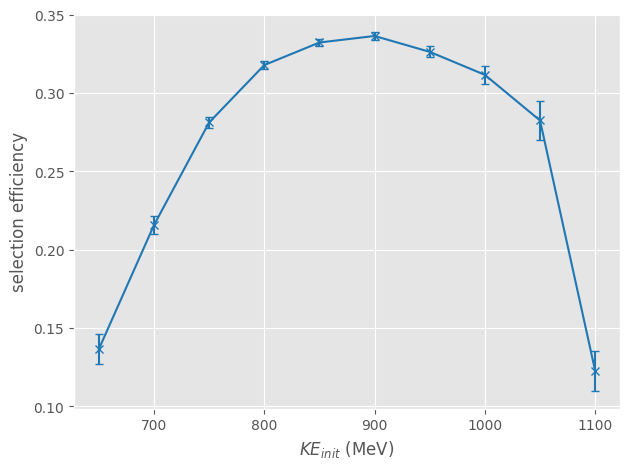

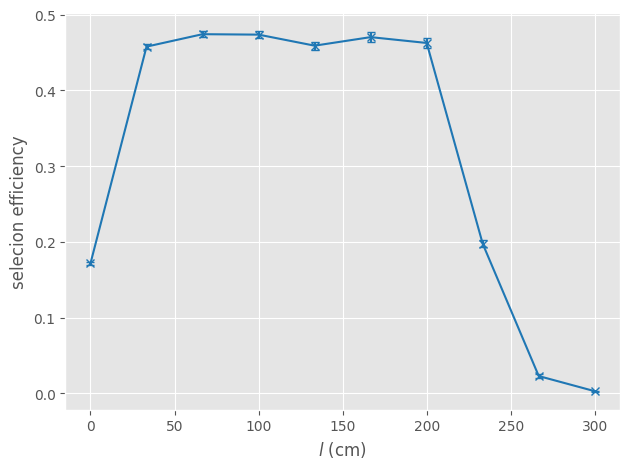

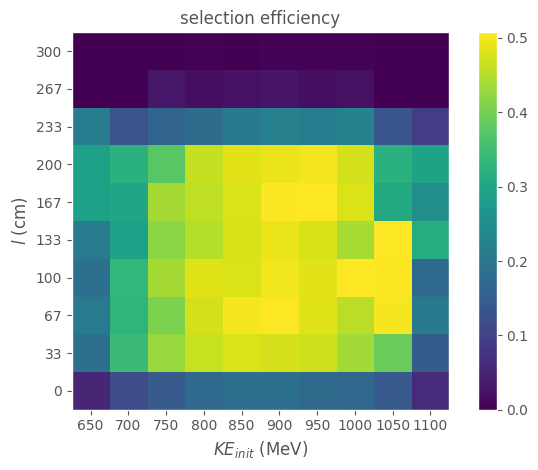

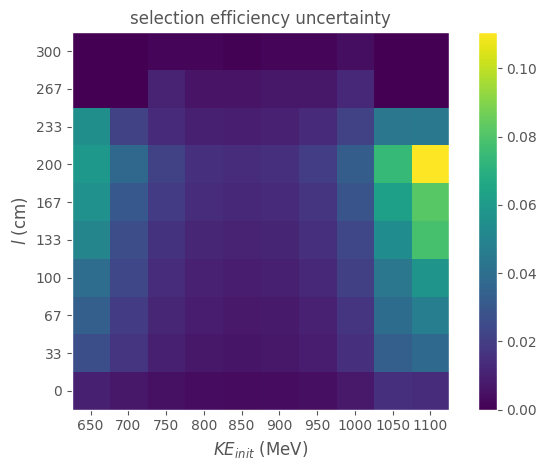

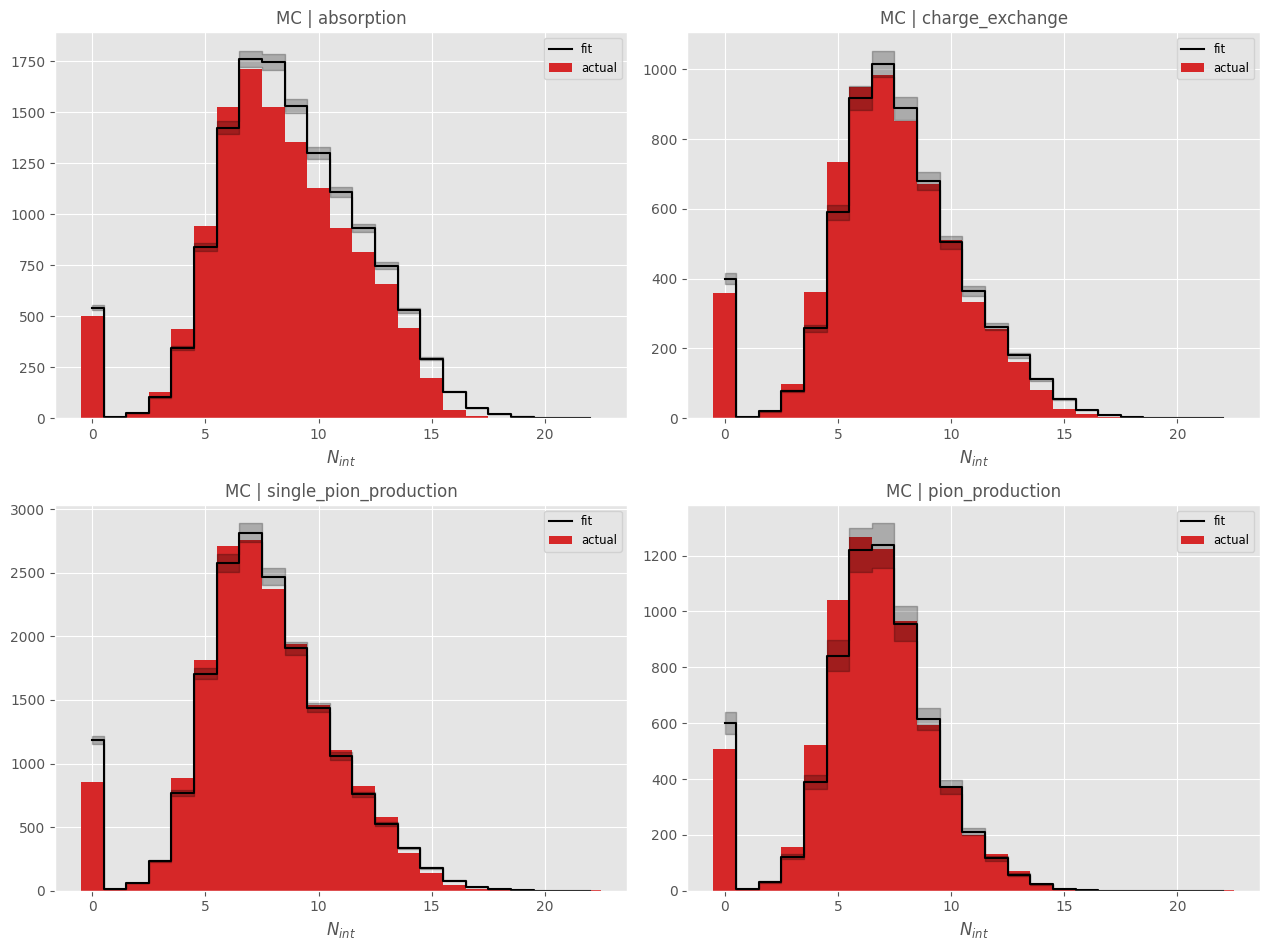

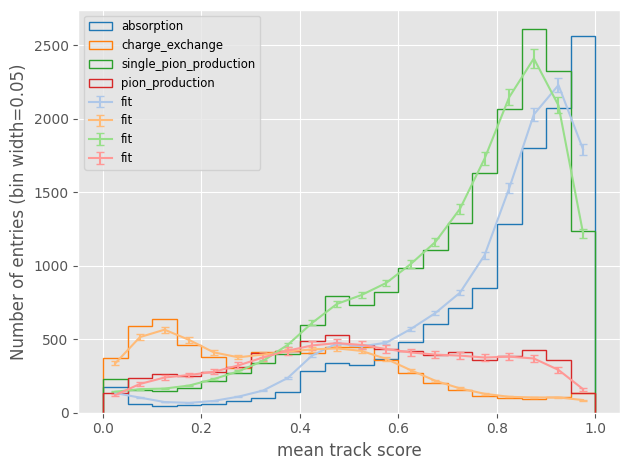

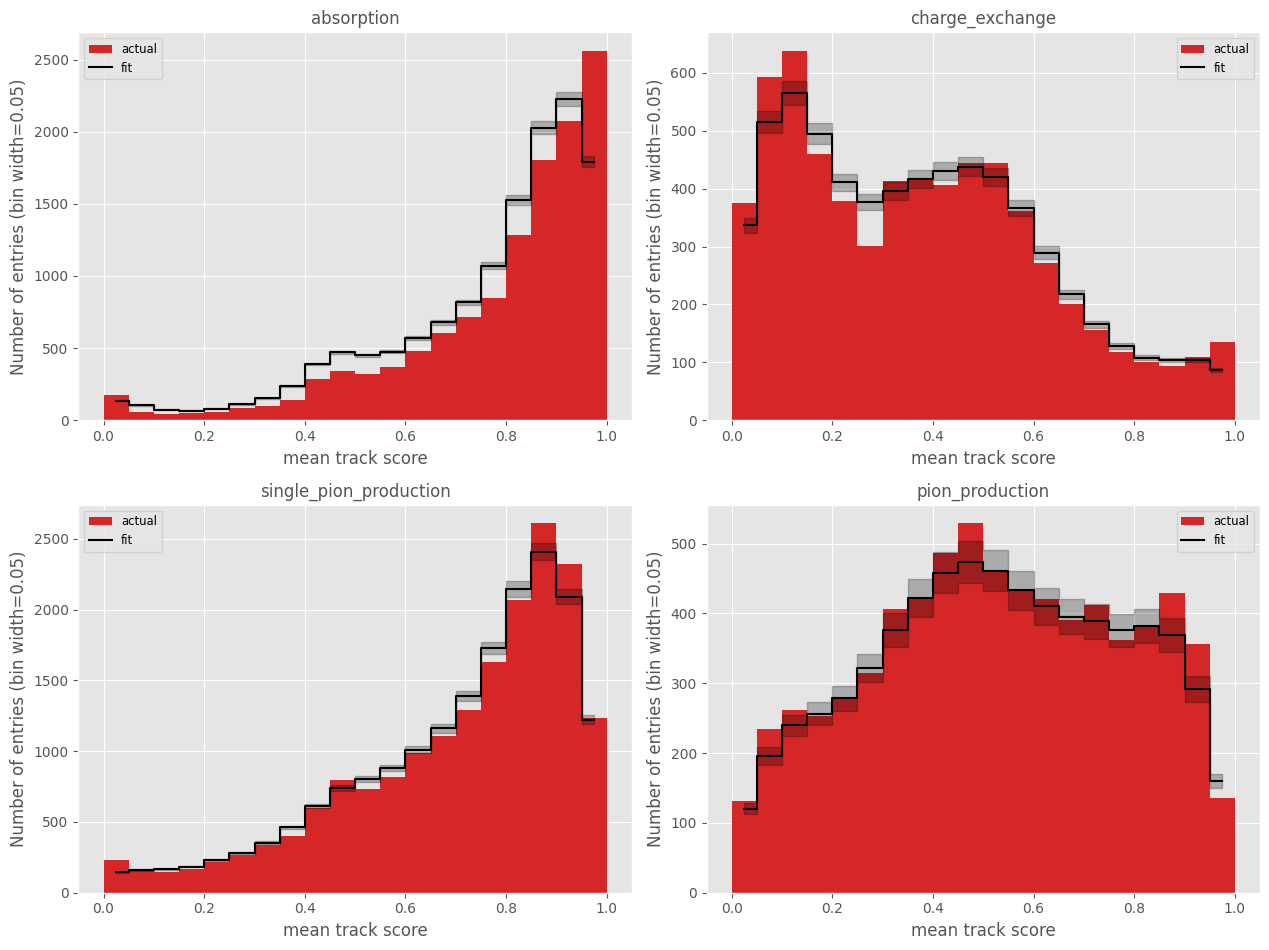

In [26]:
book = Plots.PlotBook("mc_region_fit_toy_template_unweighted.pdf", False)
fractions = EfficiencyMatrix(analysis_input_mc_s, analysis_input_mc, 10, book = book)
template_weights = CreateWeights(analysis_input_toy_template.KE_init_reco, analysis_input_toy_template.track_length_reco, fractions, 10)
FitStudy(analysis_input_mc_s, analysis_input_toy_template, book, template_weights)
book.close()

# data Analysis

In [75]:
book = Plots.PlotBook("1GeV_data_region_fit.pdf", True)

pdf 1GeV_data_region_fit.pdf has been opened


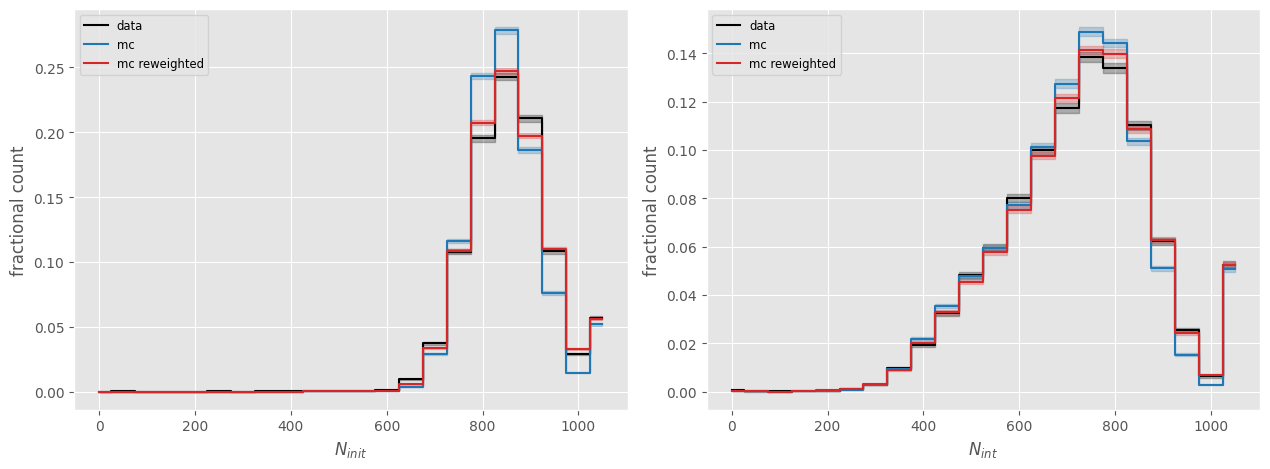

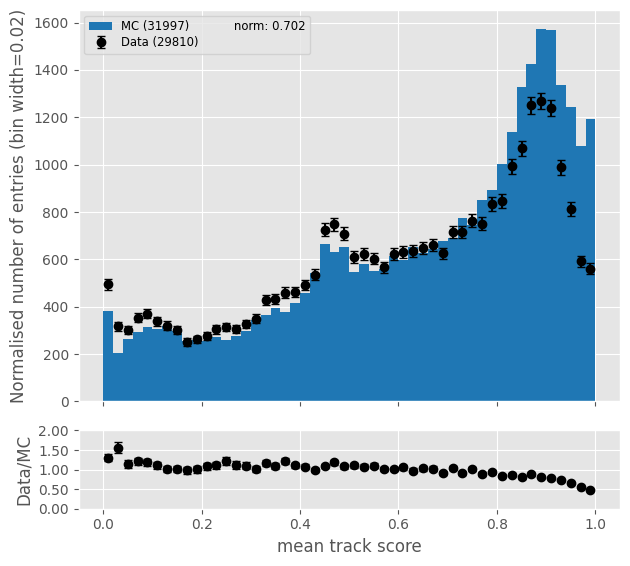

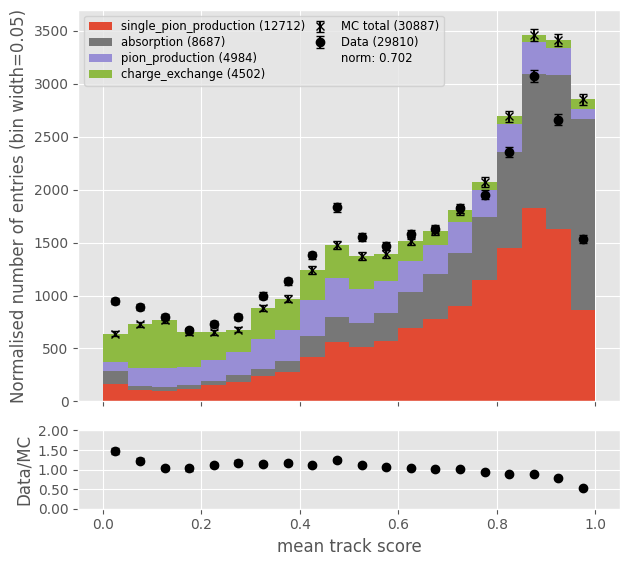

In [76]:
hist_labels = ["$N_{init}$", "$N_{int}$", "$N_{int, ex}$", "$N_{inc}$"]
hists_mc = cross_section.EnergySlice.CountingExperiment(analysis_input_mc_s.KE_int_reco, analysis_input_mc_s.KE_init_reco, analysis_input_mc_s.outside_tpc_reco, analysis_input_mc_s.exclusive_process[args.signal_process], energy_slices, False, analysis_input_mc_s.weights)
hists_mc_no_rw = cross_section.EnergySlice.CountingExperiment(analysis_input_mc_s.KE_int_reco, analysis_input_mc_s.KE_init_reco, analysis_input_mc_s.outside_tpc_reco, analysis_input_mc_s.exclusive_process[args.signal_process], energy_slices, False)
hists_data = cross_section.EnergySlice.CountingExperiment(analysis_input_data_s.KE_int_reco, analysis_input_data_s.KE_init_reco, analysis_input_data_s.outside_tpc_reco, analysis_input_data_s.regions[args.signal_process], energy_slices, False)

for i in Plots.MultiPlot(2):
    Plots.Plot(energy_overflow, hists_data[i] / sum(hists_data[i]), yerr = np.sqrt(hists_data[i]) / sum(hists_data[i]), label = "data", xlabel = hist_labels[i], newFigure = False, style = "step", color = "k", ylabel = "fractional count")
    Plots.Plot(energy_overflow, hists_mc_no_rw[i] / sum(hists_mc_no_rw[i]), yerr = np.sqrt(hists_mc_no_rw[i]) / sum(hists_mc_no_rw[i]), label = "mc", newFigure = False, style = "step", color = "C0")
    Plots.Plot(energy_overflow, hists_mc[i] / sum(hists_mc[i]), yerr = np.sqrt(hists_mc[i]) / sum(hists_mc[i]), label = "mc reweighted", newFigure = False, style = "step", color = "C6")
book.Save()

Plots.PlotHistDataMC(analysis_input_data_s.mean_track_score, analysis_input_mc_s.mean_track_score, 50, x_range = [0, 1], norm = args.norm, xlabel = "mean track score")
book.Save()

Plots.PlotTagged(analysis_input_mc_s.mean_track_score, tags = cross_section.Tags.ExclusiveProcessTags(analysis_input_mc_s.exclusive_process), data2 = analysis_input_data_s.mean_track_score, bins = mean_track_score_bins, norm = args.norm, x_label = "mean track score")
book.Save()


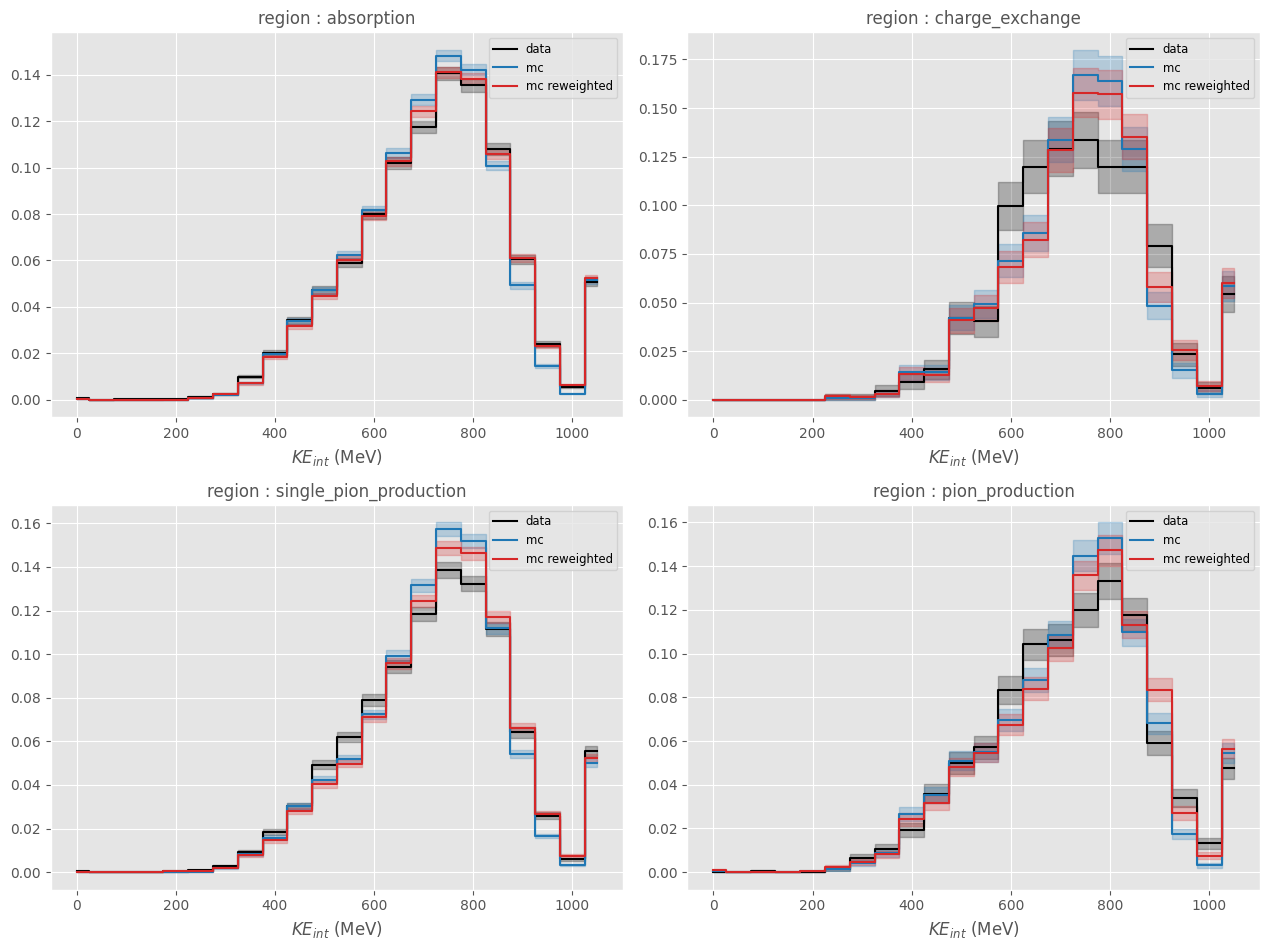

In [77]:
for _, r in Plots.IterMultiPlot(analysis_input_data_s.regions):
    n_int_data = analysis_input_data_s.NInteract(energy_slices, analysis_input_data_s.regions[r])
    n_int_mc = analysis_input_mc_s.NInteract(energy_slices, analysis_input_mc_s.regions[r], weights = analysis_input_mc_s.weights)
    n_int_mc_no_rw = analysis_input_mc_s.NInteract(energy_slices, analysis_input_mc_s.regions[r])
    Plots.Plot(energy_overflow, n_int_data / sum(n_int_data), yerr = np.sqrt(n_int_data) / sum(n_int_data), label = "data", style = "step", newFigure = False, color = "k")
    Plots.Plot(energy_overflow, n_int_mc_no_rw / sum(n_int_mc_no_rw), yerr = np.sqrt(n_int_mc_no_rw) / sum(n_int_mc_no_rw), label = "mc", style = "step", newFigure = False, xlabel = "$KE_{int}$ (MeV)", title = f"region : {r}", color = "C0")
    Plots.Plot(energy_overflow, n_int_mc / sum(n_int_mc), yerr = np.sqrt(n_int_mc) / sum(n_int_mc), label = "mc reweighted", style = "step", newFigure = False, color = "C6")
book.Save()

In [81]:
def DataFitStudy(data : cross_section.AnalysisInput, mc : cross_section.AnalysisInput):
    result = cex_analyse.RegionFit(data, energy_slices, None, mc, False, None, True)
    result_mean_track_score = cex_analyse.RegionFit(data, energy_slices, mean_track_score_bins, mc, False, None, True)

    scale = len(analysis_input_mc_s.KE_int_reco) / len(analysis_input_data_s.KE_int_reco)
    print("with mean track score")
    display(cross_section.pd.DataFrame({"fit value" : result_mean_track_score[1].bestfit[0:4] * scale, "uncertainty" : result_mean_track_score[1].uncertainty[0:4] * scale}))
    print("without mean track score")
    display(cross_section.pd.DataFrame({"fit value" : result[1].bestfit[0:4] * scale, "uncertainty" : result[1].uncertainty[0:4] * scale}))
    return result, result_mean_track_score

print("reweighting")
fit_results_rw = DataFitStudy(analysis_input_data_s, analysis_input_mc_s)

print("no reweighting")
no_rw = cross_section.AnalysisInput.FromFile("test/analysis_inputs/analysis_input_1GeV_mc_selected.dill")
no_rw.weights = None
fit_results_no_rw = DataFitStudy(analysis_input_data_s, no_rw)


reweighting

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 22, 'channel_1': 22, 'channel_2': 22, 'channel_3': 22}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_sample_0_pois_err', 'shapesys'), ('channel_0_sample_1_pois_err', 'shapesys'), ('channel_0_sample_2_pois_err', 'shapesys'), ('channel_0_sample_3_pois_err', 'shapesys'), ('channel_1_sample_0_pois_err', 'shapesys'), ('channel_1_sample_1_pois_err', 'shapesys'), ('channel_1_sample_2_pois_err', 'shapesys'), ('channel_1_sample_3_pois_err', 'shapesys'), ('channel_2_sample_0_pois_err', 'shapesys'), ('channel_2_sample_1_pois_err', 'shapesys'), ('channel_2_sample_2_pois_err', 'shapesys'), ('channel_2_sample_3_pois_err', 'shapesys'), ('channel_3_sample_0_pois_err', 'shapesys'), ('channel_3_sample_1_pois_err', 'shapesys'), ('channel_3_sample_2_pois_err', 'shapesys'), ('channel_3_sample_3_pois_err', 'shapesys'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'no

with mean track score

,fit value,uncertainty
0,0.336063,0.038727
1,1.949200,0.072510
2,1.429796,0.044345
3,0.348787,0.107553


without mean track score

,fit value,uncertainty
0,1.049969,0.048484
1,0.975382,0.073838
2,1.185823,0.042172
3,0.556351,0.094791


no reweighting

  channels: ['channel_0', 'channel_1', 'channel_2', 'channel_3']
     nbins: {'channel_0': 22, 'channel_1': 22, 'channel_2': 22, 'channel_3': 22}
   samples: ['sample_0', 'sample_1', 'sample_2', 'sample_3']
 modifiers: [('channel_0_sample_0_pois_err', 'shapesys'), ('channel_0_sample_1_pois_err', 'shapesys'), ('channel_0_sample_2_pois_err', 'shapesys'), ('channel_0_sample_3_pois_err', 'shapesys'), ('channel_1_sample_0_pois_err', 'shapesys'), ('channel_1_sample_1_pois_err', 'shapesys'), ('channel_1_sample_2_pois_err', 'shapesys'), ('channel_1_sample_3_pois_err', 'shapesys'), ('channel_2_sample_0_pois_err', 'shapesys'), ('channel_2_sample_1_pois_err', 'shapesys'), ('channel_2_sample_2_pois_err', 'shapesys'), ('channel_2_sample_3_pois_err', 'shapesys'), ('channel_3_sample_0_pois_err', 'shapesys'), ('channel_3_sample_1_pois_err', 'shapesys'), ('channel_3_sample_2_pois_err', 'shapesys'), ('channel_3_sample_3_pois_err', 'shapesys'), ('mu_0', 'normfactor'), ('mu_1', 'normfactor'), ('mu_2', 'no

with mean track score

,fit value,uncertainty
0,0.336263,0.039404
1,1.859190,0.077144
2,1.377086,0.046575
3,0.616570,0.117133


without mean track score

,fit value,uncertainty
0,0.978571,0.054852
1,0.976119,0.093159
2,1.114723,0.049570
3,0.943368,0.120784


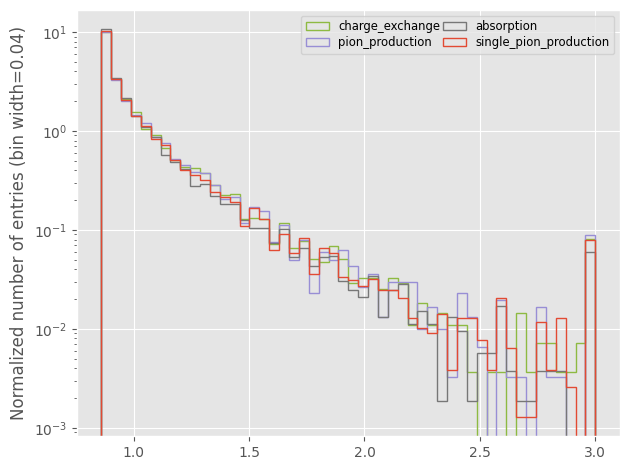

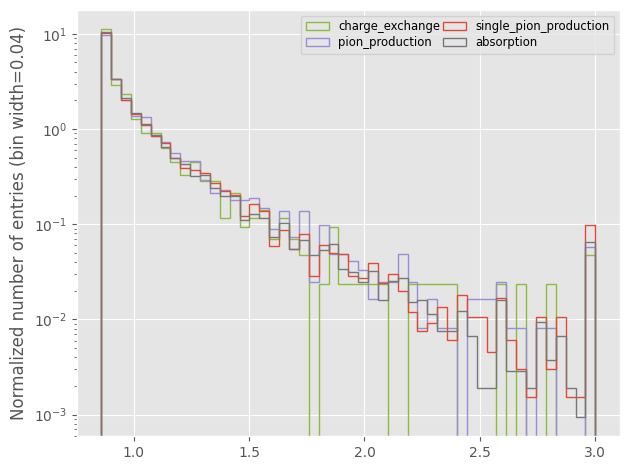

In [15]:
Plots.PlotTagged(analysis_input_mc_s.weights, cross_section.Tags.ExclusiveProcessTags(analysis_input_mc_s.exclusive_process), bins = 50, y_scale = "log", stacked = False, histtype = "step", norm = True)
Plots.PlotTagged(analysis_input_mc_s.weights, cross_section.Tags.ExclusiveProcessTags(analysis_input_mc_s.regions), bins = 50, y_scale = "log", stacked = False, histtype = "step", norm = True)

In [16]:
count_regions_mc = {k : sum(v)/len(v) for k, v in analysis_input_mc_s.regions.items()}
count_regions_mc_truth = {k : sum(v)/len(v) for k, v in analysis_input_mc_s.exclusive_process.items()}

print(count_regions_mc)
print(count_regions_mc_truth)

{
    'absorption': 0.5418705162238652,
    'charge_exchange': 0.02180733200236941,
    'single_pion_production': 0.3388473267370176,
    'pion_production': 0.06276738114565279
}

{
    'absorption': 0.27149470173976,
    'charge_exchange': 0.140716526622935,
    'single_pion_production': 0.3972927316206314,
    'pion_production': 0.15578859612557863
}

In [17]:
count_regions_data = {k : sum(v) for k, v in analysis_input_data_s.regions.items()}
count_regions_mc = {k : sum(v) for k, v in analysis_input_mc_s.regions.items()}

print(f"{count_regions_data=}")
print(f"{count_regions_mc=}")

print("rough estimate of normalisations")
scale = len(analysis_input_mc_s.KE_int_reco) / len(analysis_input_data_s.KE_int_reco)
print({k : scale * count_regions_data[k] / count_regions_mc[k] for k in count_regions_mc})

count_regions_data = {k : sum(v) for k, v in analysis_input_data_s.regions.items()}
count_regions_mc = {k : sum(analysis_input_mc_s.weights[v]) for k, v in analysis_input_mc_s.regions.items()}

print(f"{count_regions_data=}")
print(f"{count_regions_mc=}")

print("rough estimate of normalisations with weights")
scale = sum(analysis_input_mc_s.weights) / len(analysis_input_data_s.KE_int_reco)
print({k : scale * count_regions_data[k] / count_regions_mc[k] for k in count_regions_mc})

count_regions_data={'absorption': 16456, 'charge_exchange': 643, 'single_pion_production': 10734, 
'pion_production': 1977}

count_regions_mc={'absorption': 24699, 'charge_exchange': 994, 'single_pion_production': 15445, 'pion_production': 
2861}

rough estimate of normalisations

{
    'absorption': 1.0187480288503843,
    'charge_exchange': 0.9891142561507926,
    'single_pion_production': 1.0626629797066975,
    'pion_production': 1.056600189877848
}

count_regions_data={'absorption': 16456, 'charge_exchange': 643, 'single_pion_production': 10734, 
'pion_production': 1977}

count_regions_mc={'absorption': 24946.28379052434, 'charge_exchange': 996.9900811499504, 'single_pion_production': 
15730.193352595263, 'pion_production': 2942.751330369959}

rough estimate of normalisations with weights

{
    'absorption': 1.0248404929328112,
    'charge_exchange': 1.0019775521151628,
    'single_pion_production': 1.060145286118289,
    'pion_production': 1.0437367161978222
}

using KE_int,ex from region fit

signal: charge_exchange

len(KE_int_prediction.model_yields)=4

using KE_int,ex from region fit

signal: charge_exchange

len(KE_int_prediction.model_yields)=4

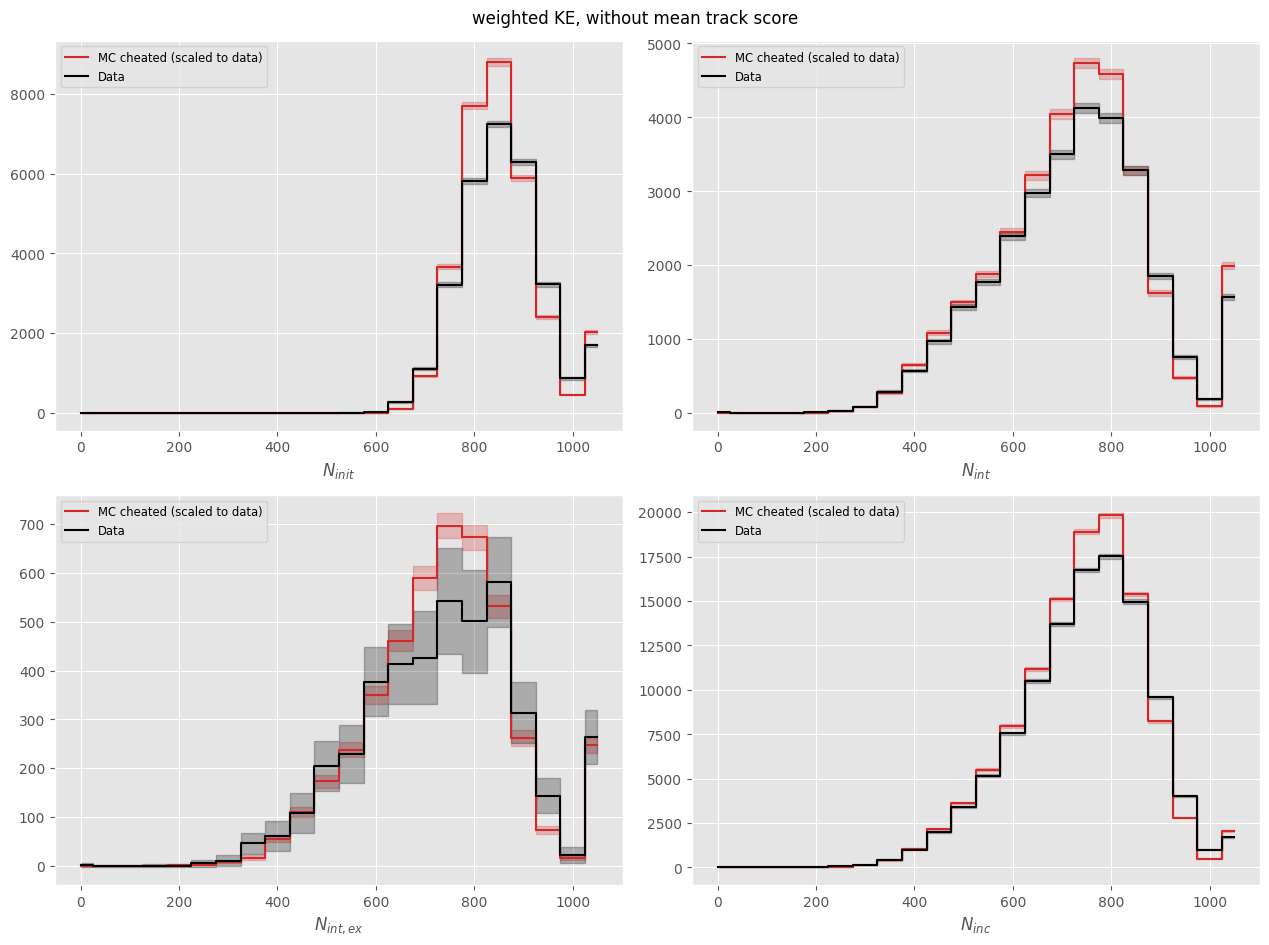

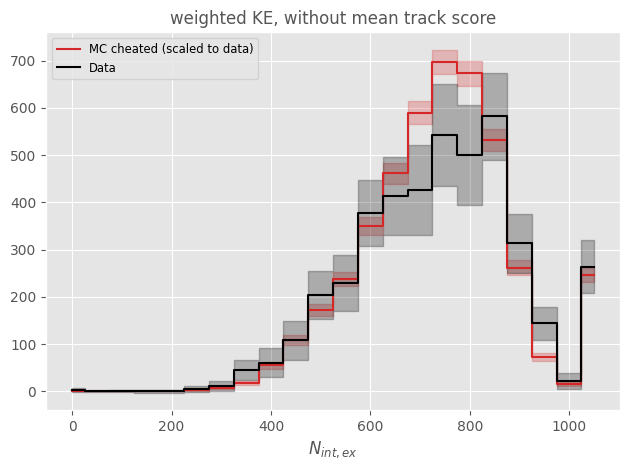

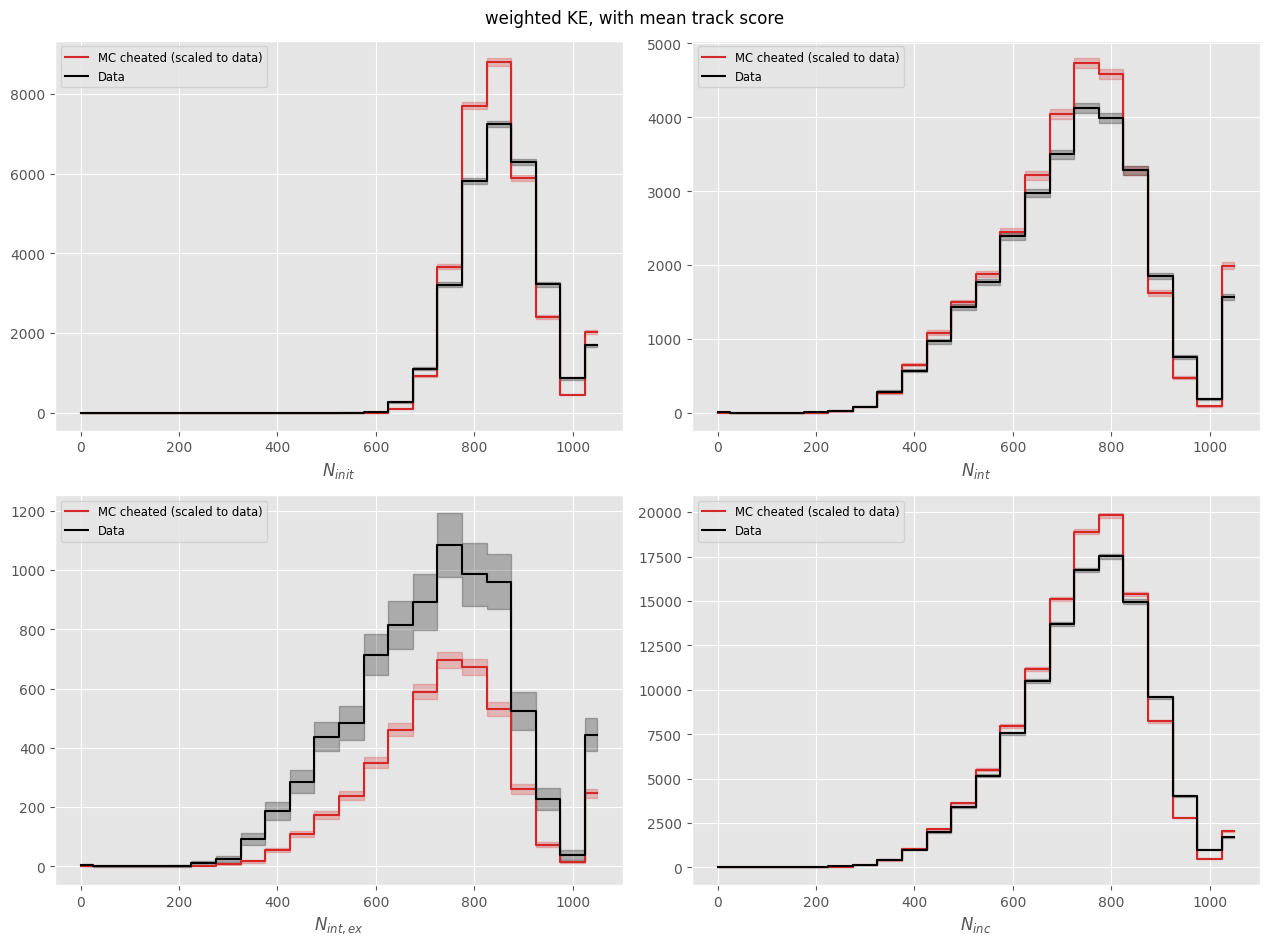

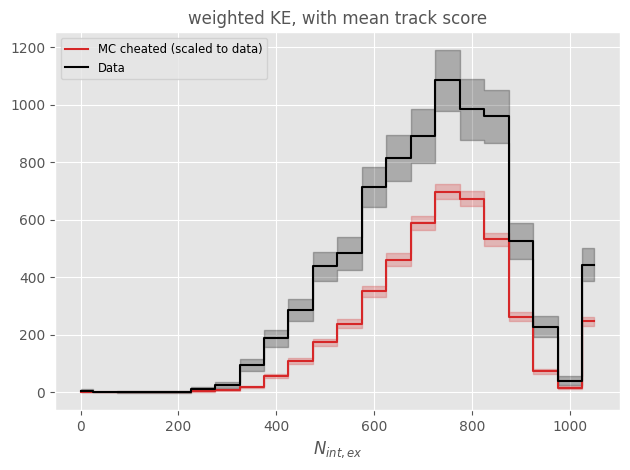

In [78]:
def PlotDataBkgSub(data : cross_section.AnalysisInput, mc : cross_section.AnalysisInput, fit_results, sample_name : str, book : Plots.PlotBook = Plots.PlotBook.null):
    labels = {"init" : "$N_{init}$", "int" : "$N_{int}$", "int_ex" : "$N_{int, ex}$", "inc" : "$N_{inc}$"}
    _, histograms_data, histograms_data_err = cex_analyse.BackgroundSubtraction(data, args.signal_process, energy_slices, fit_results)

    histograms_mc_reco = cross_section.Unfold.CreateHistograms(mc, energy_slices, args.signal_process, True, False)

    # scale = len(data.KE_init_reco) / len(mc.KE_init_reco)
    scale = args.norm

    for _, i in Plots.IterMultiPlot(histograms_data):
        Plots.Plot(energy_overflow, scale * histograms_mc_reco[i], yerr = np.sqrt(scale * histograms_mc_reco[i]), xlabel = labels[i], newFigure = False, style = "step", label = "MC cheated (scaled to data)", color = "C6")
        Plots.Plot(energy_overflow, histograms_data[i], yerr = histograms_data_err[i], xlabel = labels[i], newFigure = False, style = "step", label = "Data", color = "k")
        Plots.plt.legend(loc = "upper left")
    Plots.plt.suptitle(sample_name)
    Plots.plt.tight_layout()
    book.Save()

    Plots.Plot(energy_overflow, scale * histograms_mc_reco["int_ex"], yerr = np.sqrt(scale * histograms_mc_reco["int_ex"]), xlabel = labels["int_ex"], style = "step", label = "MC cheated (scaled to data)", color = "C6", title = sample_name)
    Plots.Plot(energy_overflow, histograms_data["int_ex"], yerr = histograms_data_err["int_ex"], xlabel = labels["int_ex"], newFigure = False, style = "step", label = "Data", color = "k")
    Plots.plt.legend(loc = "upper left")
    book.Save()

    return

PlotDataBkgSub(analysis_input_data_s, analysis_input_mc_s, fit_results_rw[0][0], "weighted KE, without mean track score", book)
PlotDataBkgSub(analysis_input_data_s, analysis_input_mc_s, fit_results_rw[1][0], "weighted KE, with mean track score", book)

using KE_int,ex from region fit

signal: charge_exchange

len(KE_int_prediction.model_yields)=4

using KE_int,ex from region fit

signal: charge_exchange

len(KE_int_prediction.model_yields)=4

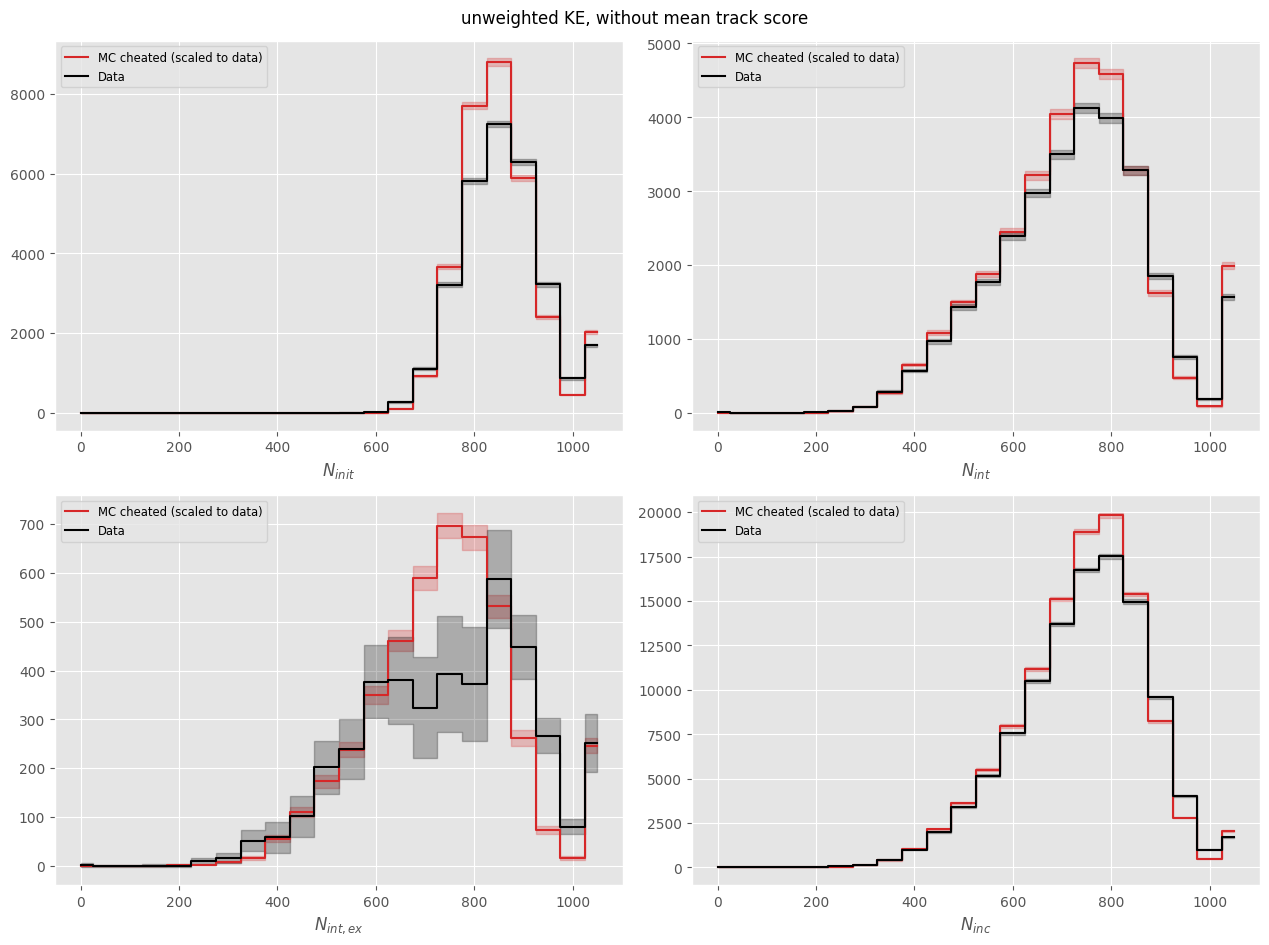

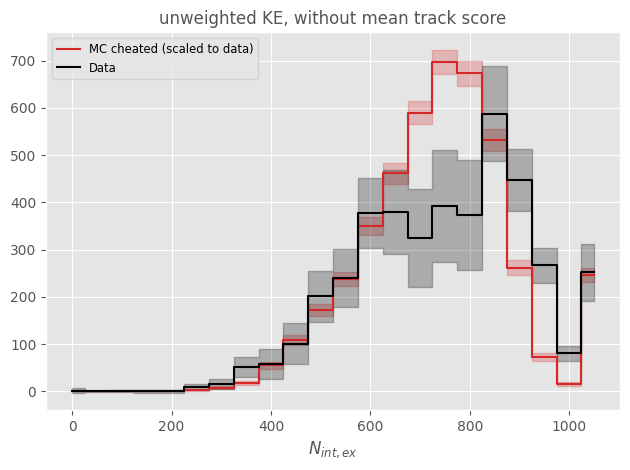

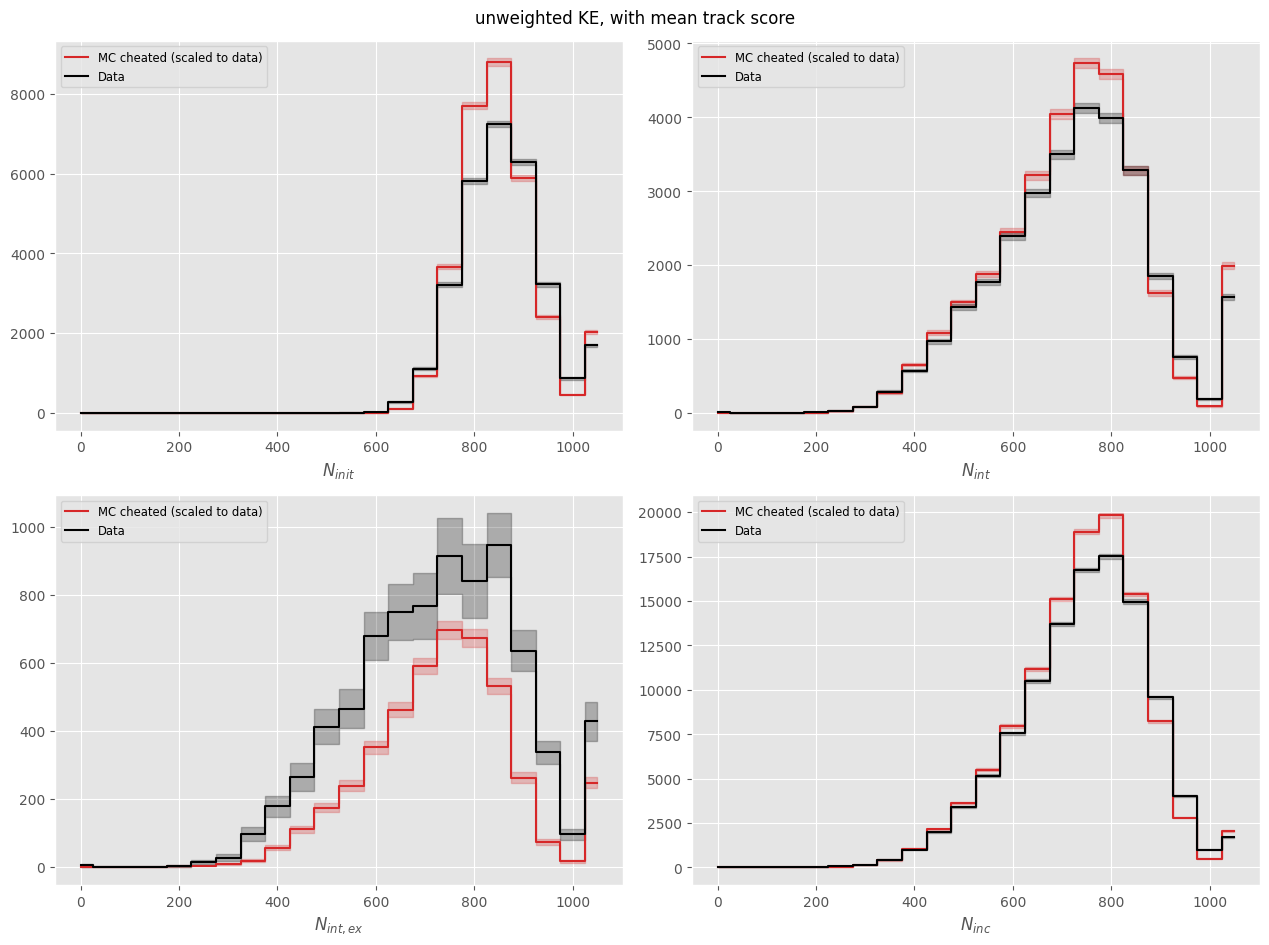

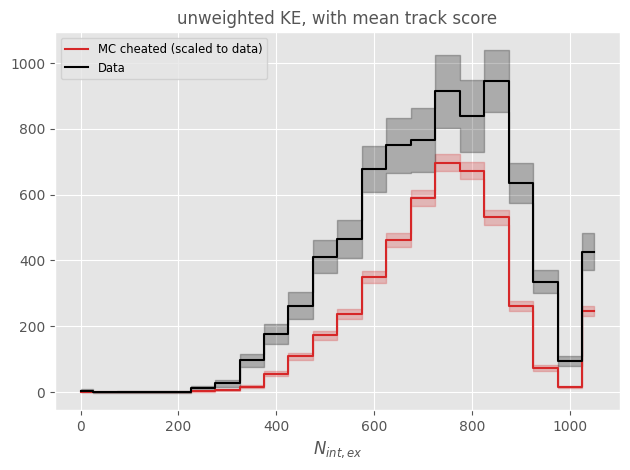

In [79]:
PlotDataBkgSub(analysis_input_data_s, analysis_input_mc_s, fit_results_no_rw[0][0], "unweighted KE, without mean track score", book)
PlotDataBkgSub(analysis_input_data_s, analysis_input_mc_s, fit_results_no_rw[1][0], "unweighted KE, with mean track score", book)

In [80]:
book.close()

pdf 1GeV_data_region_fit.pdf has been closed


# Data MC unfolding

/tmp/ipykernel_44594/3451211701.py:3: RuntimeWarning: invalid value encountered in divide
  efficiencies = {k : np.nan_to_num(true_hists_selected[k] / true_hists[k]) for k in true_hists}


{
    'init': array([0.09460714, 0.32057416, 0.46433121, 0.48395637, 0.4807931 ,
       0.45290976, 0.36100616, 0.14729242, 0.0220339 , 0.00671141,
       0.0310559 , 0.        , 0.0625    , 0.125     , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ]),
    'int': array([0.0944058 , 0.12903226, 0.38600823, 0.4173452 , 0.45888172,
       0.478036  , 0.49474904, 0.48387675, 0.46612217, 0.45135421,
       0.45173365, 0.42789722, 0.39002933, 0.28833259, 0.19027356,
       0.10916031, 0.09331919, 0.09289617, 0.08627451, 0.10648148,
       0.06451613, 0.        ]),
    'int_ex': array([0.05246684, 0.14285714, 0.34946237, 0.41742523, 0.50997506,
       0.49035442, 0.50779286, 0.51767525, 0.49773071, 0.46085998,
       0.4852071 , 0.4137931 , 0.38790932, 0.31007752, 0.15340909,
       0.140625  , 0.05434783, 0.07894737, 0.075     , 0.1       ,
       0.        , 0.        ]),
    'inc': array([0.09460714, 0.28666667, 0.45776071, 0.48348733, 0.4893392 ,
       0.47995527, 0.4587554 , 0.42788713, 0.39547923, 0.36290819,
       0.33022541, 0.28690846, 0.23620867, 0.17410714, 0.1265564 ,
       0.09839572, 0.0925545 , 0.09200806, 0.09114927, 0.10121457,
       0.06451613, 0.        ])
}

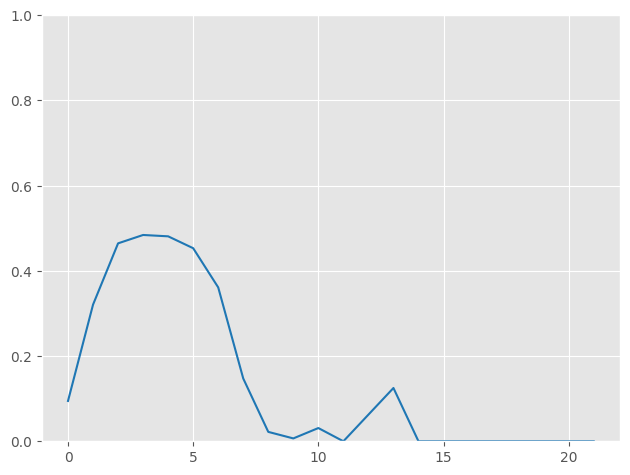

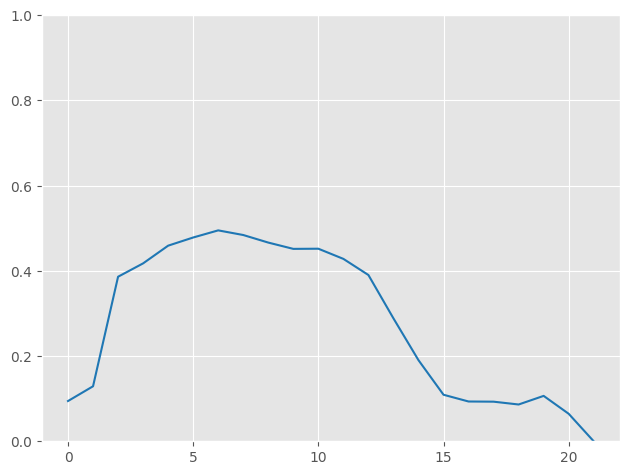

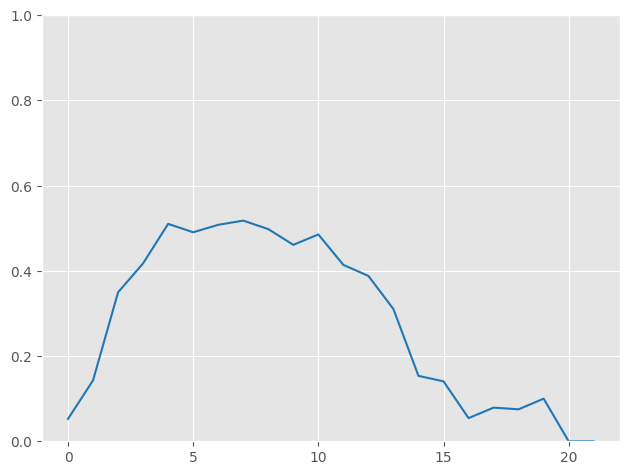

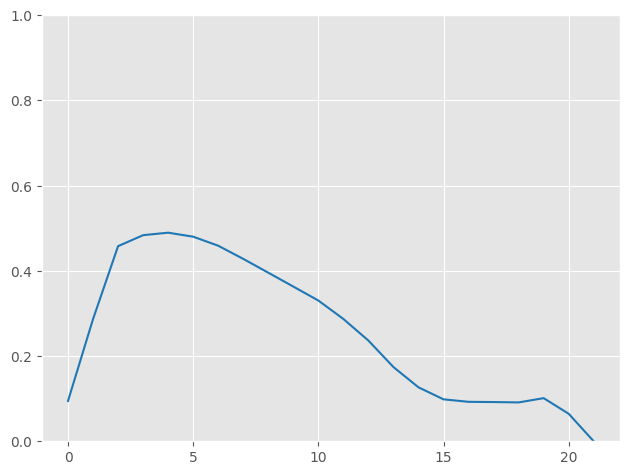

In [190]:
true_hists = cross_section.Unfold.CreateHistograms(analysis_input_mc, energy_slices, "charge_exchange", False, ~analysis_input_mc.inclusive_process)
true_hists_selected = cross_section.Unfold.CreateHistograms(analysis_input_mc_s, energy_slices, "charge_exchange", False, ~analysis_input_mc_s.inclusive_process)
efficiencies = {k : np.nan_to_num(true_hists_selected[k] / true_hists[k]) for k in true_hists}
for k, v in efficiencies.items():
    Plots.Plot(np.arange(len(v)), v)
    Plots.plt.ylim(0, 1)
print(efficiencies)

/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1455: RuntimeWarning: invalid value encountered in divide
  normalization_factor = efficiencies / column_sums
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/Plots.py:888: UserWarning: pdf has not been opened.
  warnings.warn("pdf has not been opened.")
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1455: RuntimeWarning: divide by zero encountered in divide
  normalization_factor = efficiencies / column_sums
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1456: RuntimeWarning: invalid value encountered in multiply
  response = response_hist * normalization_factor
/home/sb16165/Documents/pi0-analysis/analysis/python/analysis/cross_section.py:1457: RuntimeWarning: invalid value encountered in multiply
  response_err = response_hist_err * normalization_factor


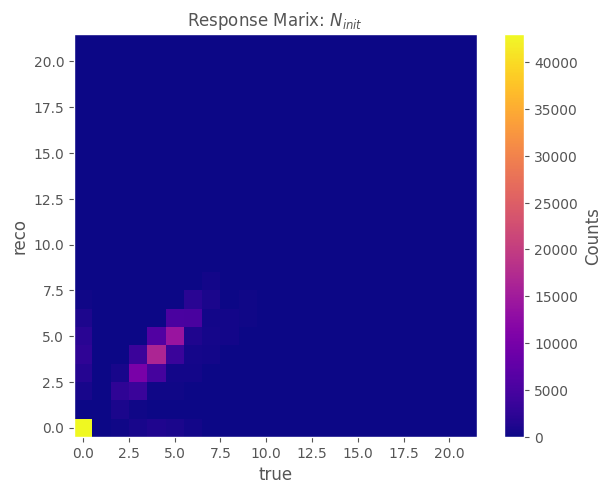

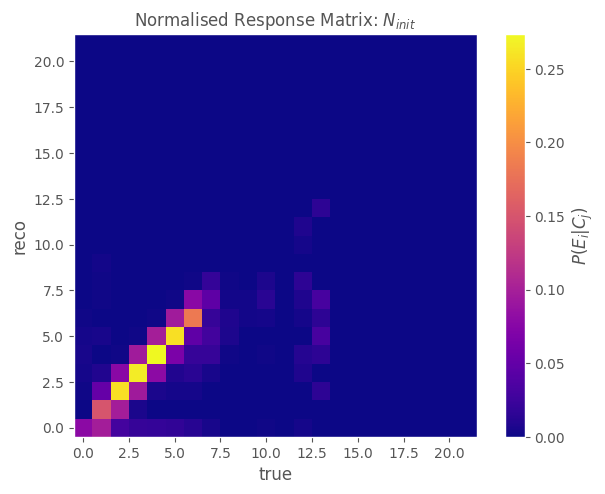

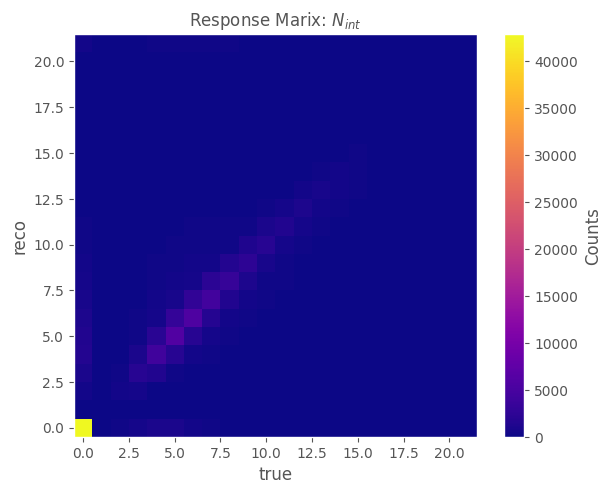

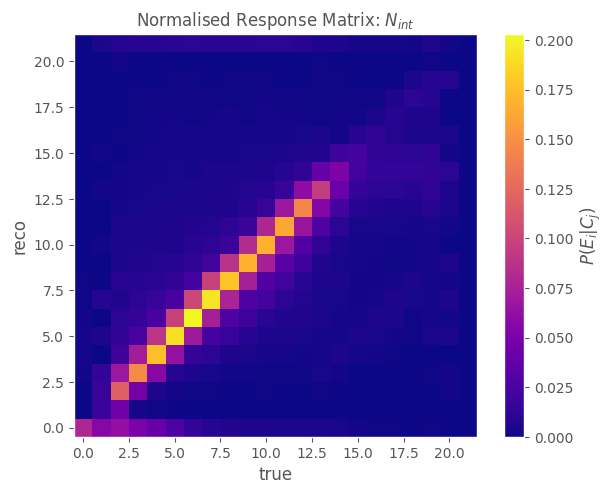

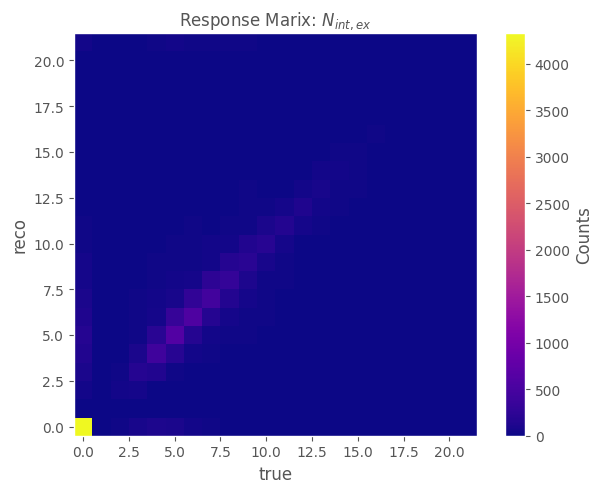

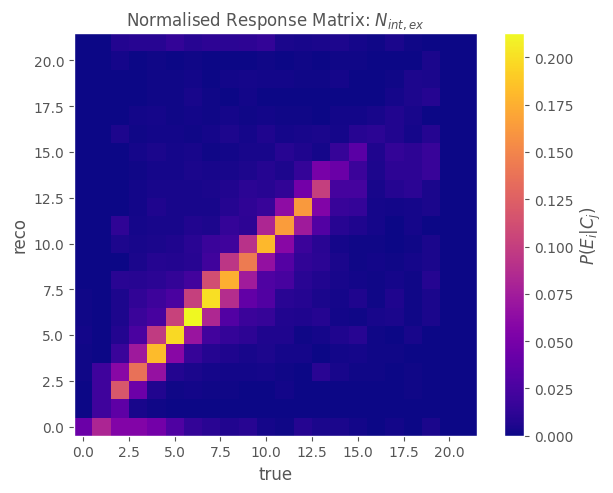

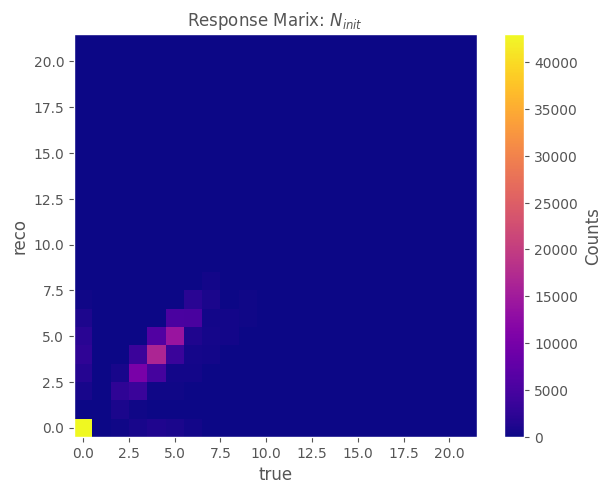

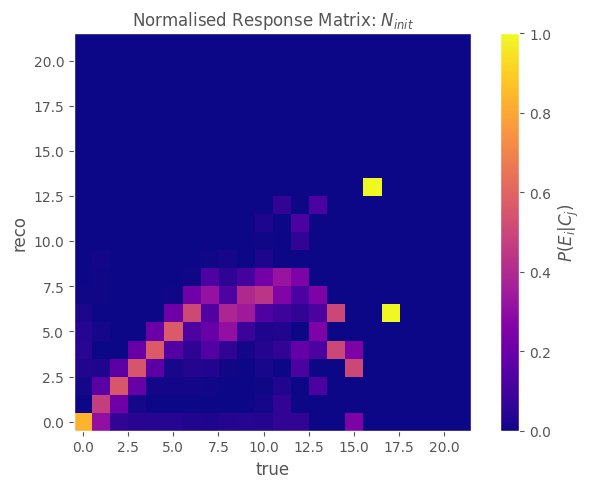

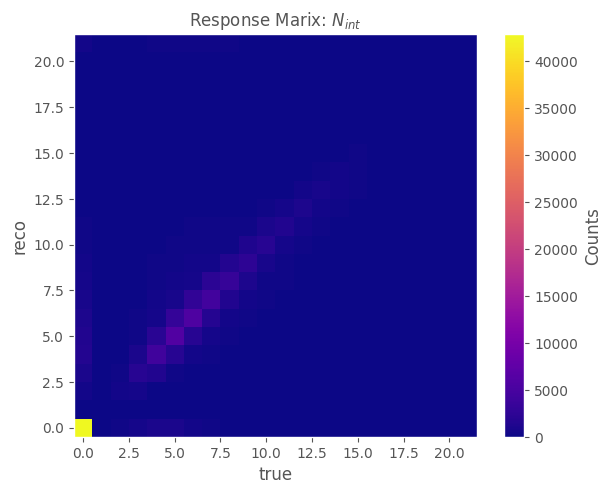

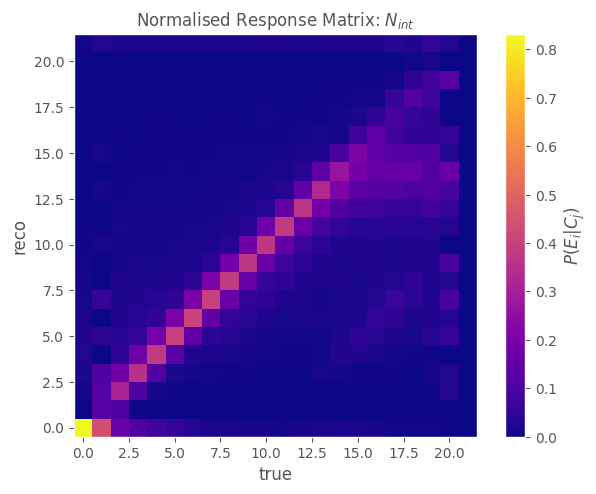

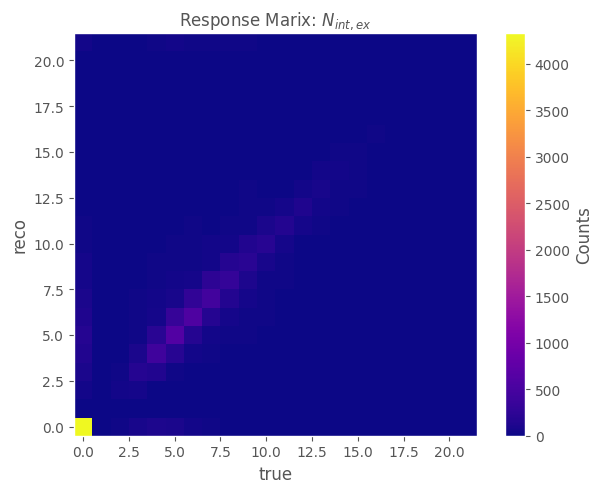

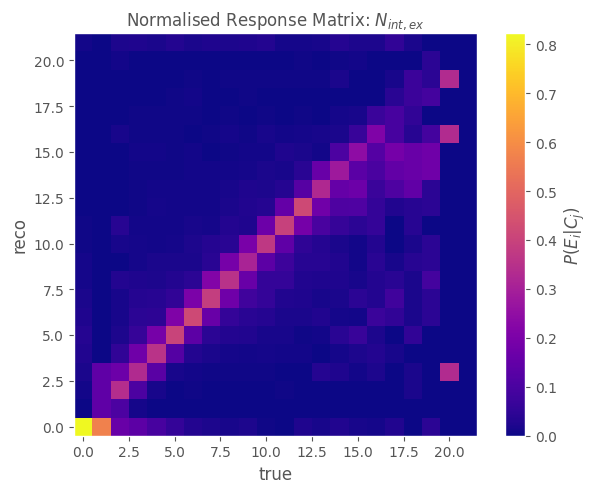

In [191]:
with Plots.PlotBook("mc_response_matrices_efficiency", False) as book:
    resp_e = cross_section.Unfold.CalculateResponseMatrices(analysis_input_mc, args.signal_process, energy_slices, book, efficiencies)
with Plots.PlotBook("mc_response_matrices", False) as book:
    resp = cross_section.Unfold.CalculateResponseMatrices(analysis_input_mc, args.signal_process, energy_slices, book, None)

In [222]:

print(sum(analysis_input_mc.outside_tpc_true))
print(sum(analysis_input_mc.outside_tpc_reco))
print(sum(~analysis_input_mc.inclusive_process))
print(sum(analysis_input_mc.outside_tpc_true | analysis_input_mc.outside_tpc_reco))
print(sum(analysis_input_mc.outside_tpc_true | analysis_input_mc.outside_tpc_reco | ~analysis_input_mc.inclusive_process))
print(sum((analysis_input_mc.KE_init_true - analysis_input_mc.KE_int_true) < 50))
print(sum(((analysis_input_mc.KE_init_true - analysis_input_mc.KE_int_true) < 50) | analysis_input_mc.outside_tpc_true | analysis_input_mc.outside_tpc_reco | ~analysis_input_mc.inclusive_process))


# slice_init, slice_int = cross_section.EnergySlice.SliceNumbers(analysis_input_mc.KE_int_true, analysis_input_mc.KE_init_true, analysis_input_mc.outside_tpc_true, energy_slices)
# print(sum(slice_init == -1))
# print(sum(slice_int == -1))

# cross_section.EnergySlice.CountingExperiment(analysis_input_mc.KE_int_true, analysis_input_mc.KE_init_true, analysis_input_mc.outside_tpc_true, analysis_input_mc.inclusive_process, energy_slices, False, analysis_input_mc.weights)

22079

26162

6347

36224

38994

48867

63166

In [193]:
observed = cross_section.Unfold.CreateHistograms(analysis_input_mc_s, energy_slices, args.signal_process, True, None)
observed_err = {k : np.sqrt(v) for k, v in observed.items()}
result = cross_section.Unfold.Unfold(observed, observed_err, resp_e, efficiencies = efficiencies, verbose = True)

Iteration 1: ts = 0.3636, ts_stopping = 0.01
Iteration 2: ts = 0.0234, ts_stopping = 0.01
Iteration 3: ts = 0.0207, ts_stopping = 0.01
Iteration 4: ts = 0.0158, ts_stopping = 0.01
Iteration 5: ts = 0.0122, ts_stopping = 0.01
Iteration 6: ts = 0.0104, ts_stopping = 0.01
Iteration 7: ts = 0.0089, ts_stopping = 0.01
Iteration 1: ts = 0.1822, ts_stopping = 0.01
Iteration 2: ts = 0.0860, ts_stopping = 0.01
Iteration 3: ts = 0.0457, ts_stopping = 0.01
Iteration 4: ts = 0.0261, ts_stopping = 0.01
Iteration 5: ts = 0.0166, ts_stopping = 0.01
Iteration 6: ts = 0.0113, ts_stopping = 0.01
Iteration 7: ts = 0.0080, ts_stopping = 0.01
Iteration 1: ts = 0.2294, ts_stopping = 0.01
Iteration 2: ts = 0.0954, ts_stopping = 0.01
Iteration 3: ts = 0.0482, ts_stopping = 0.01
Iteration 4: ts = 0.0259, ts_stopping = 0.01
Iteration 5: ts = 0.0150, ts_stopping = 0.01
Iteration 6: ts = 0.0091, ts_stopping = 0.01


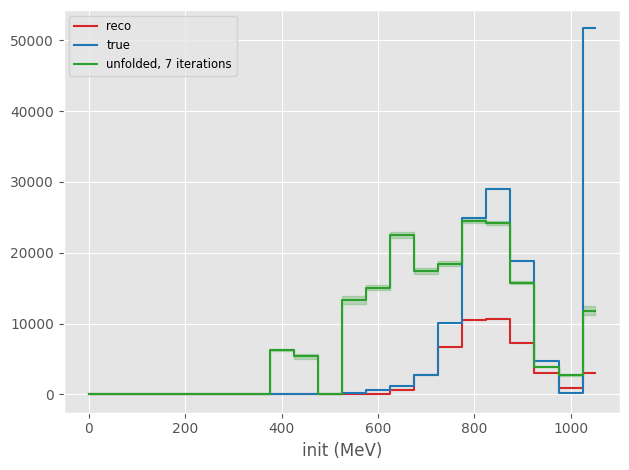

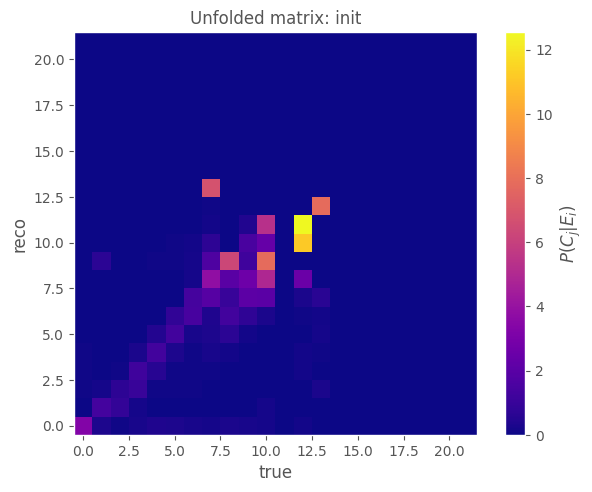

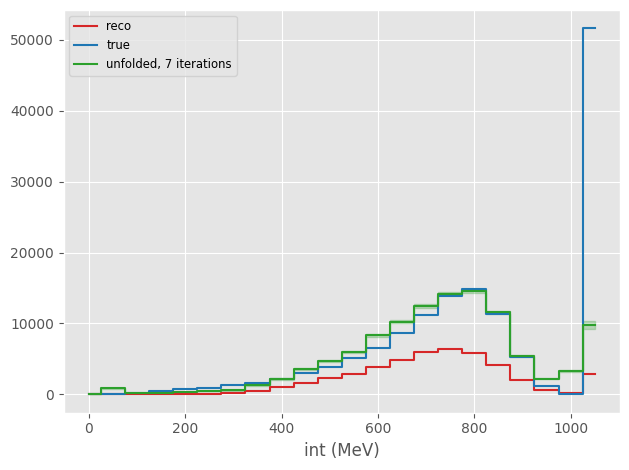

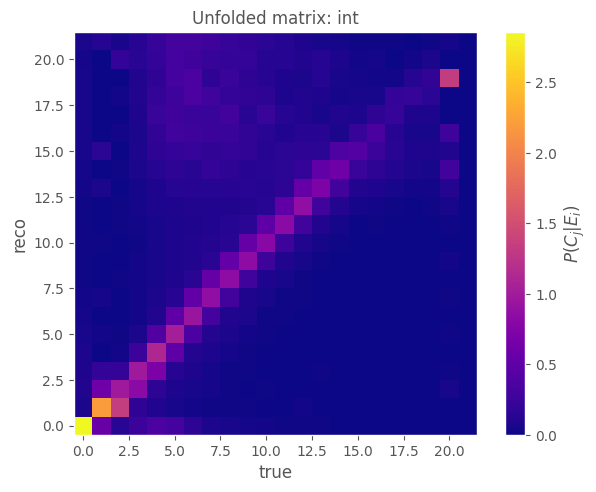

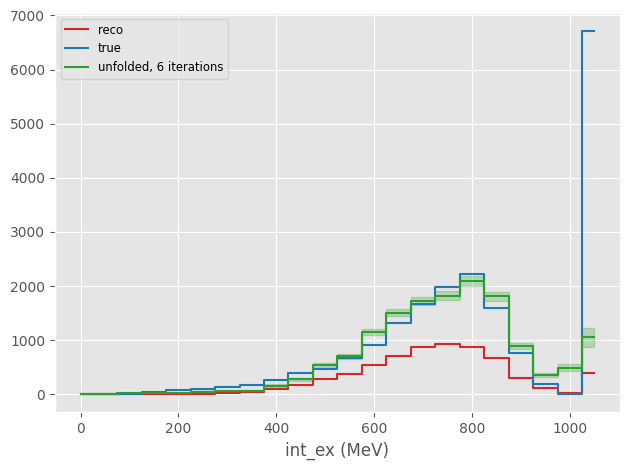

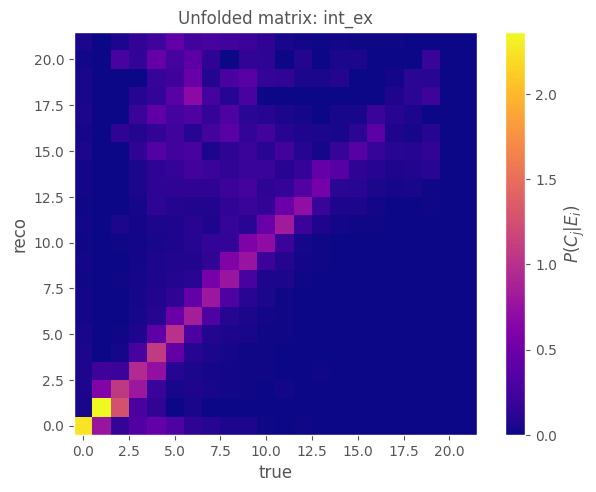

In [194]:
true_hists = cross_section.Unfold.CreateHistograms(analysis_input_mc, energy_slices, "charge_exchange", False, ~analysis_input_mc.inclusive_process)
for k in result:
    cross_section.Unfold.PlotUnfoldingResults(observed[k], true_hists[k], result[k], energy_bins, k)

# Misc

(array([[1., 0., 1., ..., 0., 0., 0.],
        [6., 0., 0., ..., 0., 0., 0.],
        [1., 4., 3., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 1., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 [array([-250., -245., -240., -235., -230., -225., -220., -215., -210.,
         -205., -200., -195., -190., -185., -180., -175., -170., -165.,
         -160., -155., -150., -145., -140., -135., -130., -125., -120.,
         -115., -110., -105., -100.,  -95.,  -90.,  -85.,  -80.,  -75.,
          -70.,  -65.,  -60.,  -55.,  -50.,  -45.,  -40.,  -35.,  -30.,
          -25.,  -20.,  -15.,  -10.,   -5.,    0.,    5.,   10.,   15.,
           20.,   25.,   30.,   35.,   40.,   45.,   50.,   55.,   60.,
           65.,   70.,   75.,   80.,   85.,   90.,   95.,  100.,  105.,
          110.,  115.,  120.,  125.,  130.,  135.,  140.,  145.,  150.,
          155.,  160.,  165.,  170.,  175.,  180.,  185.,  190.,  195.,
          200.,  205.,  210.,  

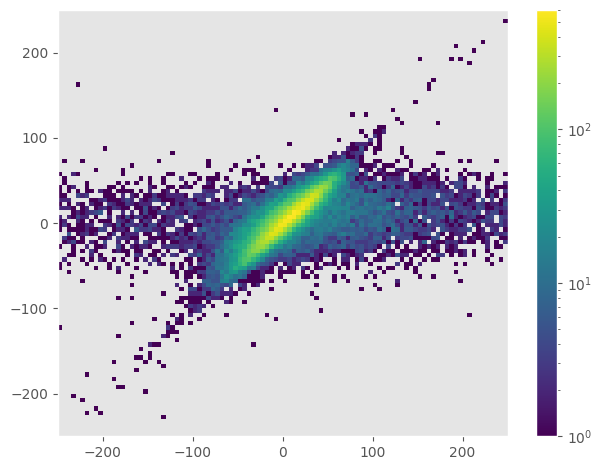

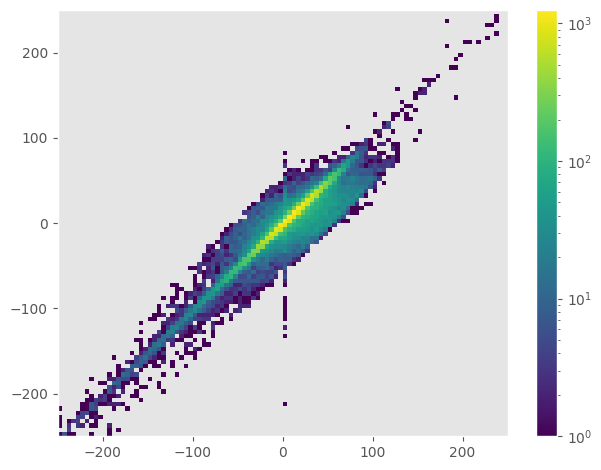

In [52]:
Plots.PlotHist2D(analysis_input_mc.KE_int_true - analysis_input_mc.KE_int_reco, analysis_input_mc.KE_init_true - analysis_input_mc.KE_init_reco, x_range = [-250, 250], y_range = [-250, 250])
Plots.PlotHist2D(analysis_input_toy.KE_int_true - analysis_input_toy.KE_int_reco, analysis_input_toy.KE_init_true - analysis_input_toy.KE_init_reco, x_range = [-250, 250], y_range = [-250, 250])